# INTEL IMAGE CLASSIFICATION- CNN PROJESİ

### Ortam ve Kütüphaneler

- **Amaç**: Notebook’u “temiz çıktı” ile çalıştırmak; TensorFlow’un C++/backend (cuDNN, cuBLAS, XLA, absl) ve Python taraflı tüm INFO/WARN loglarını ve Python `warnings` çıktısını bastırmak.
  
- **Nasıl çalışır?**
  
  - TF importundan önce çevre değişkenleri ayarlanır: `TF_CPP_MIN_LOG_LEVEL=3`, isteğe bağlı `TF_ENABLE_ONEDNN_OPTS=0`.
  
  - TensorFlow/Keras, STDOUT/STDERR yönlendirmesi altında; logger seviyesi `ERROR` olacak şekilde sessiz import edilir.
    
  - Global uyarılar kapatılır; tekrarlanabilirlik için tohumlar (`random`, `numpy`, `tf`) `SEED=42` ile sabitlenir.
    
  - “Konuşan” işlemler (dataset oluşturma, `fit`/`evaluate`/`predict`) gerektiğinde `run_silent(...)` ile çağrılarak tamamen sessiz çalıştırılır.

In [1]:
# TEMİZ AÇILIŞ 

import os, warnings, logging, io, contextlib, random
import numpy as np

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
    import tensorflow as tf
    from tensorflow import keras
    import absl.logging as absl_logging
    tf.get_logger().setLevel(logging.ERROR)
    absl_logging.set_verbosity(absl_logging.ERROR)

warnings.filterwarnings("ignore")
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

def run_silent(fn, *args, **kwargs):
    buf = io.StringIO()
    with contextlib.redirect_stdout(buf), contextlib.redirect_stderr(buf):
        return fn(*args, **kwargs)

# Durum bilgisi 
def _gpu_name():
    buf = io.StringIO()
    with contextlib.redirect_stdout(buf), contextlib.redirect_stderr(buf):
        g = tf.config.list_physical_devices('GPU')
        if not g: return "Yok"
        d = tf.config.experimental.get_device_details(g[0])
        return d.get("device_name") or "GPU"
print(f"TensorFlow: {tf.__version__}")
print(f"GPU      : {_gpu_name()}")


E0000 00:00:1758725450.924247      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758725450.976483      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow: 2.18.0
GPU      : Tesla P100-PCIE-16GB


# 2- Veri Seti ve Yükleme Akışı
- **Kaynak**: Kaggle “Intel Image Classification”  sınıflar: buildings, forest, glacier, mountain, sea, street.
 
- **Ayrım**: Eğitim/doğrulama `seg_train/seg_train` içinden `validation_split=0.2`; test `seg_test/seg_test` klasöründen.
  
- **Yükleme**: `keras.utils.image_dataset_from_directory` ile `train_ds`, `val_ds`, `test_ds` oluşturulur; hedef boyut `(224,224)`, batch `32`.
  
- **Bilgiler**: Sınıf adları ve sayılar yazdırılır; klasör bazlı toplam örnek sayıları hesaplanır; bir batch şekli doğrulanır.
  
- **Görselleştirme**: İlk 25 örnek görüntülenir; eğitim ve test sınıf dağılımları çubuk grafiklerle sunulur.
  
- **Not**: Bu hücre ham piksel değerlerini yükler; normalizasyon/augmentation sonraki “Veri Ön İşleme” adımında uygulanır.

Found 14034 files belonging to 6 classes.
Using 11228 files for training.


I0000 00:00:1758725471.691768      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.
Sınıf sayısı: 6
Sınıflar: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Eğitim toplam (kaynak klasör): 14034
Test toplam: 3000
Bir batch şekli: (32, 224, 224, 3)
Train örnek ~ 11232
Val örnek ~ 2816


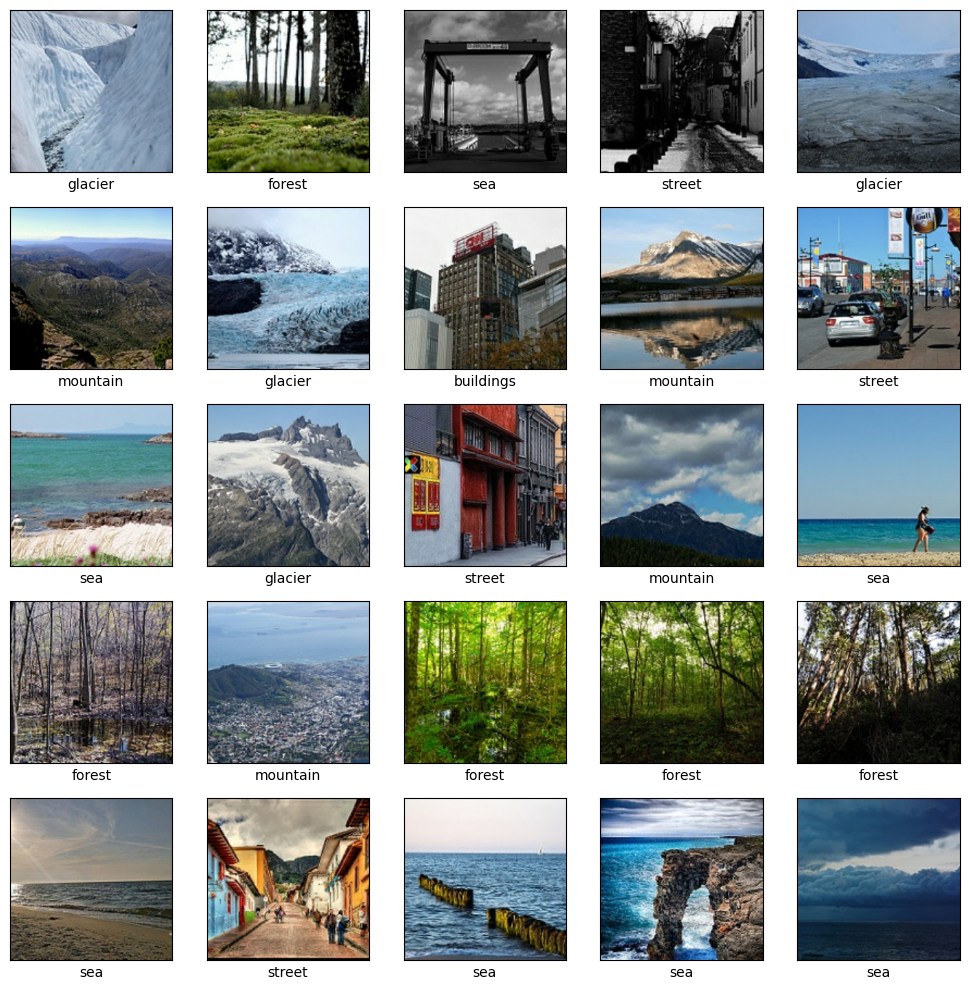

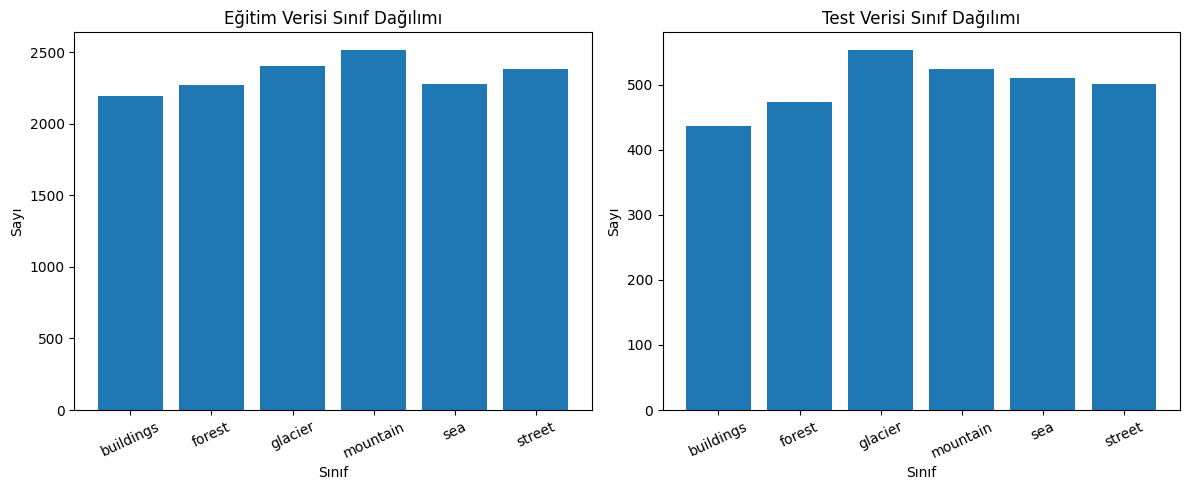

In [2]:
# Intel Image Classification - veri yükleme, örnek görseller, sınıf dağılımı

import os, numpy as np, matplotlib.pyplot as plt, seaborn as sns, tensorflow as tf
from tensorflow import keras
from pathlib import Path

SEED=42; IMG_SIZE=(224,224); BATCH_SIZE=32
DATA_DIR="/kaggle/input/intel-image-classification/seg_train/seg_train"
TEST_DIR="/kaggle/input/intel-image-classification/seg_test/seg_test"

#  Datasetleri yükle (train/val/test)
train_ds = keras.utils.image_dataset_from_directory(
    DATA_DIR, validation_split=0.2, subset="training", seed=SEED,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE
)
val_ds = keras.utils.image_dataset_from_directory(
    DATA_DIR, validation_split=0.2, subset="validation", seed=SEED,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE
)
test_ds = keras.utils.image_dataset_from_directory(
    TEST_DIR, image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False
)

# 1) Sınıf isimleri ve sayısı
class_names = train_ds.class_names
print("Sınıf sayısı:", len(class_names))
print("Sınıflar:", class_names)

# 2) Toplam görüntü sayıları (klasör sayımı)
def dir_class_counts(root):
    root = Path(root)
    return {d.name: len(list((root/d.name).glob("*"))) for d in sorted(root.iterdir()) if d.is_dir()}
def count_images(root):
    root = Path(root)
    return sum(len(list((root/c).glob("*"))) for c in class_names)

train_counts = dir_class_counts(DATA_DIR)
test_counts  = dir_class_counts(TEST_DIR)

print("Eğitim toplam (kaynak klasör):", count_images(DATA_DIR))
print("Test toplam:", count_images(TEST_DIR))

# 3) Batch/tensor boyutu 
xb, yb = next(iter(train_ds.take(1)))
print("Bir batch şekli:", xb.shape)  # (BATCH_SIZE, 224, 224, 3)

# 4) Train/Val örnek sayısı 
train_batches = tf.data.experimental.cardinality(train_ds).numpy()
val_batches   = tf.data.experimental.cardinality(val_ds).numpy()
print("Train örnek ~", train_batches * BATCH_SIZE)
print("Val örnek ~",   val_batches * BATCH_SIZE)

# 5) İlk 25 görüntüyü görselleştir 
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1); plt.xticks([]); plt.yticks([]); plt.grid(False)
    plt.imshow(xb[i].numpy().astype("uint8"))
    plt.xlabel(class_names[int(yb[i].numpy())])
plt.tight_layout(); plt.show()

# 6) Sınıf dağılımı — çubuk grafik
COLOR = "#1f77b4"  
train_x, train_y = list(train_counts.keys()), list(train_counts.values())
test_x,  test_y  = list(test_counts.keys()),  list(test_counts.values())

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.bar(train_x, train_y, color=COLOR)
plt.title("Eğitim Verisi Sınıf Dağılımı"); plt.xlabel("Sınıf"); plt.ylabel("Sayı"); plt.xticks(rotation=25)

plt.subplot(1,2,2)
plt.bar(test_x, test_y, color=COLOR)
plt.title("Test Verisi Sınıf Dağılımı"); plt.xlabel("Sınıf"); plt.ylabel("Sayı"); plt.xticks(rotation=25)

plt.tight_layout(); plt.show()

# 3- Veri Ön İşleme 

- **Neden önemli?**

  
  - **Tutarlılık**: Farklı kaynaklardan gelen görüntüler aynı ölçeğe ve dağılıma getirilir; modelin öğrenmesi kolaylaşır.
  
  - **Genelleme**: Augmentation, eğitim veri çeşitliliğini artırarak overfitting’i azaltır.
    
  - **Doğru kayıp fonksiyonu**: Etiket biçimi (one‑hot vs. tamsayı) ile loss seçimi eşleşmelidir.
    

- **Normalizasyon (`rescale=1./255`)**

 
  - Piksel değerlerini [0,1] aralığına ölçekler.
    
  - Sayısal istikrarı artırır; daha hızlı ve stabil öğrenme sağlar.
    
  - Eğitim/val/test için aynı biçimde uygulanır.

- **Veri artırma (yalnızca eğitim)**

  
  - `rotation_range`, `width/height_shift_range`, `zoom_range`, `horizontal_flip` ile küçük, gerçekçi dönüşümler uygulanır.
   
  - Modeli konum, ölçek ve yön değişimlerine karşı daha dayanıklı hale getirir.
    
  - Doğrulama/test üzerinde uygulanmaz; adil değerlendirme korunur.

- **One‑hot encoding (`class_mode="categorical"`)**

  
  - Etiketleri C‑boyutlu olasılık vektörüne dönüştürür.
    
  - Bu nedenle modelde `loss='categorical_crossentropy'` kullanılacaktır.
    
  - Alternatifte (tamsayı etiket), `sparse_categorical_crossentropy` gerekir.

- **Ayrım ve deterministiklik**

  
  - Doğrulama, eğitim klasöründen `validation_split=0.2` ile ayrılır.
    
  - `seed=SEED` ve val/test’te `shuffle=False` ile aynı örnek sırası korunur; sonuçlar tekrarlanabilir olur.

- **Çıkış kontrolü**

  
  - İlk batch’te veri şekilleri yazdırılır: giriş `(BATCH_SIZE, 224, 224, 3)`, etiket `(BATCH_SIZE, 6)`; boru hattının doğru kurulduğu doğrulanır.

In [3]:
import io, contextlib
from tensorflow import keras

SEED=42; IMG_SIZE=(224,224); BATCH_SIZE=32
DATA_DIR="/kaggle/input/intel-image-classification/seg_train/seg_train"
TEST_DIR="/kaggle/input/intel-image-classification/seg_test/seg_test"

train_gen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, validation_split=0.2,
    rotation_range=15, width_shift_range=0.1, height_shift_range=0.1,
    horizontal_flip=True, zoom_range=0.1
)

# val_gen / test_gen: Doğrulama ve test için SADECE normalizasyon (adalet için augmentation yok)
val_gen  = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# flow_from_directory çağrıları klasör tarama çıktısı üretir; stdout'u geçici olarak susturuyoruz
with contextlib.redirect_stdout(io.StringIO()):
    # Eğitim akışı
    # -class_mode="categorical" => one-hot etiketler (loss: categorical_crossentropy ile uyumlu)
    # - subset="training"        => validation_split dışındaki %80 kısım
    # - shuffle=True             => her epoch başında veriyi karıştır (genelleme için önemli)
    train_flow = train_gen.flow_from_directory(
        DATA_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
        class_mode="categorical", subset="training", seed=SEED, shuffle=True
    )
    # Doğrulama akışı
    # - subset="validation" => eğitim kökünden ayrılan %20 kısım
    # - shuffle=False        => metriklerin tekrarlanabilirliği için sabit sıra
    val_flow = val_gen.flow_from_directory(
        DATA_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
        class_mode="categorical", subset="validation", seed=SEED, shuffle=False
    )
    # Test akışı (bağımsız klasör)
    # - shuffle=False => tahmin/raporlama sırasında örnek sırası korunur
    test_flow = test_gen.flow_from_directory(
        TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
        class_mode="categorical", shuffle=False
    )
# Not: Eğitim sırasında (epoch ilerlerken) generator her batch'te:
# görüntüyü okur -> normalize eder -> augmentation uygular -> one-hot etiketi verir.
Xb, yb = next(train_flow)
print(f"Normalize edilmiş eğitim verisi şekli: {Xb.shape}")
print(f"One-hot encoded eğitim etiketleri şekli: {yb.shape}")

Normalize edilmiş eğitim verisi şekli: (32, 224, 224, 3)
One-hot encoded eğitim etiketleri şekli: (32, 6)


# 4-Temel CNN Modeli

- **Girdi/Çıkış**:

  - Girdi boyutu: `(224, 224, 3)`; RGB görüntü.
    
  - Çıkış: `Dense(num_classes, activation='softmax')` — çok sınıflı olasılık dağılımı.
    
  - Kayıp: `categorical_crossentropy` (etiketler one‑hot olduğundan).

- **Blok tasarımı (3 konvolüsyon bloğu)**:

  - Her blok: `Conv2D → BatchNormalization → Conv2D → MaxPooling2D → Dropout`.
    
  - Filtre sayıları: 32 → 64 → 128; derinlik arttıkça temsil gücü artar.
    
  - `padding='same'`: kenar bilgisini korur, uzamsal çözünürlüğü blok başında sabitler.
 
    
  - `BatchNormalization`: iç dağılım kaymasını azaltır; daha stabil ve hızlı yakınsama.
 
  - `MaxPooling2D(2,2)`: uzamsal boyutu yarıya indirip öznitelik yoğunluğunu arttırır.
 
    
  - `Dropout`: 0.2 → 0.3 → 0.4; derine indikçe overfitting riskine karşı oran artar.

- **Sınıflandırıcı (Tam Bağlantılı katmanlar)**:
  
  - `Flatten` sonrası `Dense(128, relu) → BatchNormalization → Dropout(0.5)`.
    
  - Amaç: konvolüsyonel öznitelikleri doğrusal olmayan birleştirmeyle ayırabilir kılmak.
 
    
  - Son katman `Softmax`: sınıf olasılıklarını üretir.

- **Optimizasyon ve eğitim ayarları**:
 
  - Optimizasyon: `Adam(lr=1e-3)` — pratikte iyi çalışan adaptif yöntem.
    
  - Metrik: `accuracy`.
 
    
  - Etiket biçimi: `class_mode='categorical'` ile üretilen one‑hot; loss ile uyumlu.

- **Tasarım gerekçesi**:

  - 3 bloklu mimari, Intel Image veri seti boyutu için yeterli kapasite/hesap maliyeti dengesi sağlar.
    
  - Artan dropout ve ara BN katmanları, overfitting’i sınırlayıp genelleme performansını iyileştirir.
 
  - `Flatten` tabanlı kafa, sınıf ayrımını yoğun özellik uzayında öğrenir; gerektiğinde `GlobalAveragePooling2D` alternatif olarak denenebilir.
 


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def create_cnn_model_functional(num_classes=6, input_shape=(224, 224, 3)):
    # Girdi katmanını tanımla
    inputs = keras.Input(shape=input_shape)

    # 1. Katman Bloku
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.2)(x)

    # 2. Katman Bloku
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.3)(x)

    # 3. Katman Bloku
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same', name="last_conv_layer")(x)
    # **ÖNEMLİ:** Buraya bir isim verdik. "last_conv_layer"
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.4)(x)
    
    # Global Average Pooling (isteğe bağlı, Grad-CAM için kolaylık sağlar)
    # x = layers.GlobalAveragePooling2D()(x)

    # Tam Bağlantılı Katmanlar
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    # Çıkış katmanı
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    # Modeli oluştur
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Yeni modeli oluştur ve eski modeli değiştirecek şekilde kullan
cnn_model = create_cnn_model_functional(num_classes=6, input_shape=(224,224,3))

# Geri kalanı aynı: derleme ve özet
cnn_model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv_layer (Conv2D)        │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,134,374 (50.10 MB)

 Trainable params: 13,133,670 (50.10 MB)

 Non-trainable params: 704 (2.75 KB)

# 5- Modeli Derleme ve Eğitim

 **Girdi/Etiket**: `train_flow` ve `val_flow` one‑hot etiket üretir → kayıp: `categorical_crossentropy`.

 **Optimizasyon**: `Adam(lr=1e-3)` hızlı ve kararlı yakınsama sağlar.

 **Metrik**: `accuracy` (çok sınıflı doğruluk).

 **Erken durdurma**: `EarlyStopping(monitor="val_loss", mode="min", patience=10, restore_best_weights=True)

  - Küçük dalgalanmaları iyileşme saymaz; plato gördüğünde erken durur.

 **Öğrenme oranı takvimi**: `ReduceLROnPlateau(monitor="val_loss", mode="min", factor=0.2, patience=5, min_lr=1e-4)`
  
  - İlerleme durunca LR’ı düşürür; daha küçük adımlarla ilerler.

 **Model kaydı**:
 
  - `ModelCheckpoint(save_best_only=True, monitor="val_loss", mode="min")` → en iyi ağırlıklar `.keras` olarak diske yazılır (`/kaggle/working/artifacts`).
    
  - Ek olarak her epoch sonu: `cnn_last.keras` kaydı.

 **Çıktı/Log temizliği**:
 
  - TF importundan önce: `TF_CPP_MIN_LOG_LEVEL=3`
  - TF/ABSL logger’lar `ERROR` seviyesinde.
  - Gerekirse OS‑düzeyi `stderr` geçici olarak kapatılır; epoch ilerlemesi görünür kalır.

- **Eğitim çıktısı**: `verbose=1` ile epoch özeti görünür; toplam süre yazdırılır ve `accuracy/val_accuracy` ile `loss/val_loss` grafikleri çizilir.

### Raporlama ve Yorum
- **Eğrilerin birlikte iyileşmesi** iyi genelleme işaretidir
  
- **Plato/erken durdurma**: `val_loss` belirgin iyileşmiyorsa 50 epocha varmadan durur; en iyi ağırlıklar geri yüklenir.
  
- **Overfitting sinyali**: Eğitim doğruluğu artarken doğrulama doğruluğu plato yapar ve doğrulama kaybı yükselirse; augmentation/regularization artırılabilir veya `Dropout`/`L2` güçlendirilebilir.
  
- **Kaydetme garantisi**: En iyi modelin diske yazılması “Run All + Commit” sonrasında yeniden eğitimi gereksiz kılar.

Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.5689 - loss: 1.1607
Epoch 1: val_loss improved from inf to 3.64971, saving model to /kaggle/working/artifacts/cnn_best.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 199s 520ms/step - accuracy: 0.5691 - loss: 1.1602 - val_accuracy: 0.1940 - val_loss: 3.6497 - learning_rate: 0.0010
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.7310 - loss: 0.7337
Epoch 2: val_loss improved from 3.64971 to 1.02200, saving model to /kaggle/working/artifacts/cnn_best.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 125s 355ms/step - accuracy: 0.7310 - loss: 0.7337 - val_accuracy: 0.6113 - val_loss: 1.0220 - learning_rate: 0.0010
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.7758 - loss: 0.6316
Epoch 3: val_loss improved from 1.02200 to 1.00008, saving model to /kaggle/working/artifacts/cnn_best.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 125s 357ms/step - accuracy: 0.7758 - loss: 0.6316 - val_accuracy: 0.7111 - val_loss: 1.0001 - 

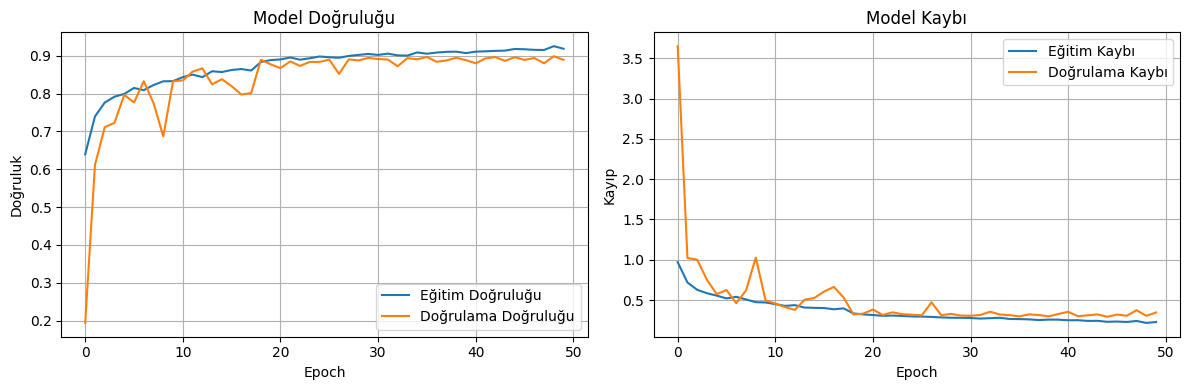

In [5]:
# --- Uyarıları tamamen kapat (TF importundan ÖNCE) ---
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # INFO/WARN gizle
ART_DIR = "/kaggle/working/artifacts"; os.makedirs(ART_DIR, exist_ok=True)

# --- Importlar ve logger seviyeleri ---
import time, matplotlib.pyplot as plt, logging as pylog
import tensorflow as tf
from absl import logging as absl_logging
from tensorflow import keras

tf.get_logger().setLevel(pylog.ERROR)
absl_logging.set_verbosity(absl_logging.ERROR)
absl_logging._warn_preinit_stderr = 0

# --- OS düzeyi stderr'i susturan context (C++/XLA/CUDA gürültüsü yok) ---
class suppress_stderr_fd:
    def __enter__(self):
        self._null = open(os.devnull, 'w')
        self._stderr_fd = os.dup(2)
        os.dup2(self._null.fileno(), 2)  # fd=2 -> /dev/null
        return self
    def __exit__(self, *exc):
        os.dup2(self._stderr_fd, 2); os.close(self._stderr_fd); self._null.close()

# --- Modeli derle ---
cnn_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# --- Callback'ler (EarlyStopping + LR planı + Kayıt) ---
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=5, min_lr=1e-4, verbose=1
)
ckpt_best = keras.callbacks.ModelCheckpoint(
    filepath=f"{ART_DIR}/cnn_best.keras",
    monitor="val_loss", mode="min", save_best_only=True, verbose=1
)
ckpt_last = keras.callbacks.ModelCheckpoint(
    filepath=f"{ART_DIR}/cnn_last.keras",
    save_best_only=False, verbose=0
)

# --- Eğitim (uyarılar tamamen kapalı) ---
start_time = time.time()
with suppress_stderr_fd():
    history = cnn_model.fit(
        train_flow,
        epochs=50,
        validation_data=val_flow,
        callbacks=[early_stopping, reduce_lr, ckpt_best, ckpt_last],
        verbose=1
    )

print(f"Eğitim süresi: {time.time() - start_time:.2f} saniye")
print("Kaydedilenler ->", f"{ART_DIR}/cnn_best.keras", "ve", f"{ART_DIR}/cnn_last.keras")

# --- Grafikler ---
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Eğitim Doğruluğu")
plt.plot(history.history["val_accuracy"], label="Doğrulama Doğruluğu")
plt.title("Model Doğruluğu"); plt.xlabel("Epoch"); plt.ylabel("Doğruluk")
plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Eğitim Kaybı")
plt.plot(history.history["val_loss"], label="Doğrulama Kaybı")
plt.title("Model Kaybı"); plt.xlabel("Epoch"); plt.ylabel("Kayıp")
plt.legend(); plt.grid(True)

plt.tight_layout(); plt.show()

# 6- Model Değerlendirme — Temel CN

 **Amaç**: En iyi modeli kullanarak test setinde değerlendirme yapmak; uyarısız/temiz çıktı üretmek ve tüm çıktı dosyalarını diske kaydetmek.
  
 **Girdi varsayımları**:
  
  - `cnn_model`: eğitimden gelen Keras modeli (RAM’de).
  - `test_flow`: `ImageDataGenerator(...).flow_from_directory(..., shuffle=False)` ile oluşturulmuş test akışı.
    
 **Log susturma**:
  - `TF_CPP_MIN_LOG_LEVEL=3` ve TF/ABSL logger’ları `ERROR` seviyesine çekilir.
  - C++ kaynaklı uyarılar için `stderr` geçici olarak `/dev/null`’e yönlendirilir (epoch çıktıları etkilenmez).
    
 **En iyi modeli kullanma**:

  - Varsa `"/kaggle/working/artifacts/cnn_best.keras"` yüklenir; yoksa RAM’deki modelle devam edilir.
    
- **Değerlendirme adımları**:

  
  - `test_flow.reset()` ardından `model.evaluate(..., verbose=0)` ile `Test Loss/Accuracy`.
    
  - `model.predict(test_flow)` → `y_prob` → `argmax` ile `y_pred`.
 
    
  - `classification_report(y_true, y_pred, target_names=class_names)` konsola yazılır ve dosyaya kaydedilir.
 
    
  - `confusion_matrix` görselleştirilir ve PNG olarak kaydedilir.
 
    
  - Testten tek batch alınarak doğru/yanlış tahminlerden örnek pano oluşturulur ve PNG olarak kaydedilir.
 
    
- **Kayıtlar (artefaktlar)**:

  
  - `baseline_report.txt`: sınıflandırma raporu (precision/recall/f1).
    
  - `baseline_cm.png`: karmaşıklık matrisi.
 
    
  - `baseline_examples.png`: doğru/yanlış örnek panosu.
 
    
  - `metrics_summary.json`: `baseline_test_acc`, `baseline_test_loss`, `class_names`.
 
    
  - (Eğitimden geliyorsa) `cnn_best.keras`, `cnn_last.keras`.
 
    
- **Yollar**: Tüm dosyalar `"/kaggle/working/artifacts"` altında üretilir; sürüme dahil etmek için commit’te output/working’i ekleyin.

Best model dosyadan yüklendi.
Test Loss: 0.3316
Test Accuracy: 0.8950

Sınıflandırma Raporu:
               precision    recall  f1-score   support

   buildings     0.9165    0.8535    0.8839       437
      forest     0.9627    0.9810    0.9718       474
     glacier     0.8878    0.8445    0.8656       553
    mountain     0.8811    0.8190    0.8490       525
         sea     0.8460    0.9588    0.8989       510
      street     0.8900    0.9202    0.9048       501

    accuracy                         0.8950      3000
   macro avg     0.8974    0.8962    0.8957      3000
weighted avg     0.8959    0.8950    0.8943      3000



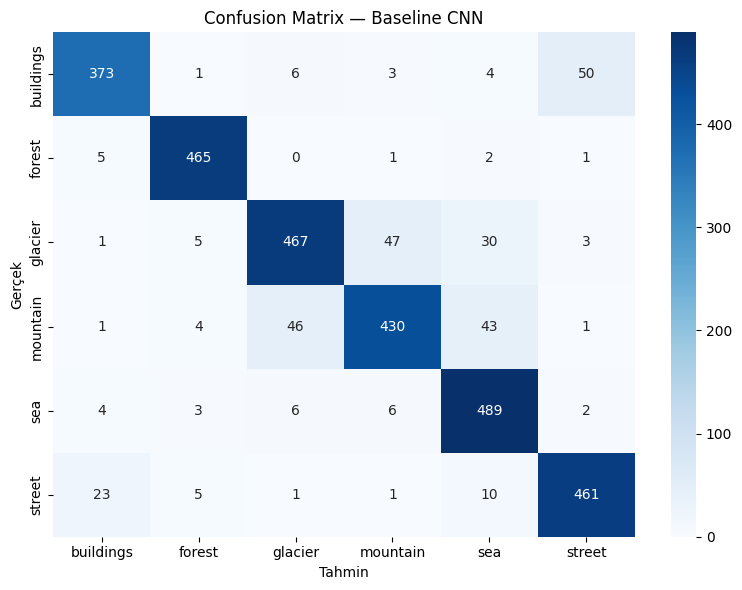

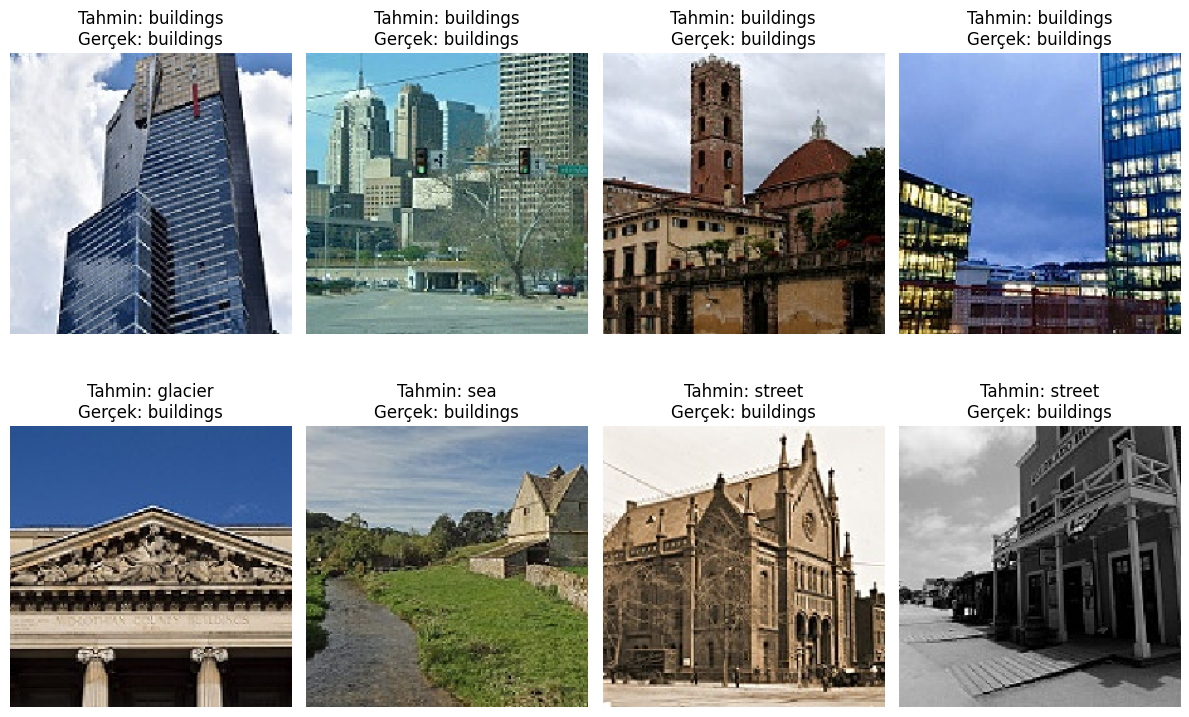

Kaydedildi -> /kaggle/working/artifacts


In [6]:
# --- 1) Uyarıları/INFO'ları sustur ---
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # TF C++ INFO/WARN susturma (importtan önce etkili ama burada da dursun)

import io, json, contextlib, logging as pylog
import numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from absl import logging as absl_logging

# Python/TF/ABSL logger seviyeleri
tf.get_logger().setLevel(pylog.ERROR)
absl_logging.set_verbosity(absl_logging.ERROR)
absl_logging._warn_preinit_stderr = 0

# C++ tarafı stderr gürültüsünü geçici kapatmak için context manager
class suppress_stderr_fd:
    def __enter__(self):
        self._null = open(os.devnull, 'w')
        self._stderr_fd = os.dup(2)
        os.dup2(self._null.fileno(), 2)  # fd=2 (stderr) -> /dev/null
        return self
    def __exit__(self, *exc):
        os.dup2(self._stderr_fd, 2); os.close(self._stderr_fd); self._null.close()

def run_silent_err(fn, *args, **kwargs):
    # Yalnızca stderr’i susturur; stdout (print/epoch barı) görünür kalır
    buf = io.StringIO()
    with contextlib.redirect_stderr(buf):
        return fn(*args, **kwargs)

# --- 2) Artefakt klasörü ve en iyi modeli yükleme (varsa) ---
ART_DIR = "/kaggle/working/artifacts"
os.makedirs(ART_DIR, exist_ok=True)
BEST = f"{ART_DIR}/cnn_best.keras"

# Not: Eğer eğitim hücresinde ModelCheckpoint ile en iyi model kaydedildiyse
# burada o modeli yükleyip değerlendirmeyi her zaman "en iyi epoch" ağırlıklarıyla yaparız.
if os.path.exists(BEST):
    with suppress_stderr_fd():
        cnn_model = keras.models.load_model(BEST)
    print("Best model dosyadan yüklendi.")
else:
    print("Best model dosyası bulunamadı; RAM'deki model ile değerlendirilecek.")

# --- 3) Test metrikleri (loss/accuracy) ---
# Bazı generator’lar reset ister; yoksa pass
try: test_flow.reset()
except Exception: pass

with suppress_stderr_fd():
    test_loss, test_acc = cnn_model.evaluate(test_flow, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# --- 4) Tüm test için tahminler ---
with suppress_stderr_fd():
    y_prob = cnn_model.predict(test_flow, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

# Gerçek etiketler ve sınıf adları
y_true = test_flow.classes
class_names = list(test_flow.class_indices.keys())

# --- 5) Sınıflandırma raporu (stdout + dosya) ---
rep = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print("\nSınıflandırma Raporu:\n", rep)
with open(f"{ART_DIR}/baseline_report.txt", "w", encoding="utf-8") as f:
    f.write(rep)

# --- 6) Confusion Matrix (PNG olarak kaydet) ---
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix — Baseline CNN")
plt.xlabel("Tahmin"); plt.ylabel("Gerçek")
plt.tight_layout()
plt.savefig(f"{ART_DIR}/baseline_cm.png", dpi=150, bbox_inches="tight")
plt.show()

# --- 7) Doğru/Yanlış örnek panosu (testten tek batch) ---
# test_flow.shuffle=False ise deterministik ilk batch döner
imgs, labels = next(test_flow)
with suppress_stderr_fd():
    probs = cnn_model.predict(imgs, verbose=0)
preds = np.argmax(probs, axis=1)
gts   = np.argmax(labels, axis=1)

correct_idx   = np.where(preds == gts)[0][:4]
incorrect_idx = np.where(preds != gts)[0][:4]

plt.figure(figsize=(12,8))
# Doğru tahminler
for i, idx in enumerate(correct_idx):
    plt.subplot(2,4,i+1)
    # test_gen’de rescale=1/255 olduğu için görselleştirmede 0-255 ölçeğine geri çıkarıyoruz
    plt.imshow((imgs[idx]*255).astype("uint8"))
    plt.title(f"Tahmin: {class_names[preds[idx]]}\nGerçek: {class_names[gts[idx]]}")
    plt.axis("off")
# Yanlış tahminler
for i, idx in enumerate(incorrect_idx):
    plt.subplot(2,4,i+5)
    plt.imshow((imgs[idx]*255).astype("uint8"))
    plt.title(f"Tahmin: {class_names[preds[idx]]}\nGerçek: {class_names[gts[idx]]}")
    plt.axis("off")
plt.tight_layout()
plt.savefig(f"{ART_DIR}/baseline_examples.png", dpi=150, bbox_inches="tight")
plt.show()

# --- 8) Özet metrikleri JSON olarak kaydet ---
summary_path = f"{ART_DIR}/metrics_summary.json"
summary = {}
# Var ise mevcut JSON’u yükle ve güncelle
if os.path.exists(summary_path):
    try:
        with open(summary_path, "r", encoding="utf-8") as f:
            summary = json.load(f)
    except Exception:
        summary = {}

summary["baseline_test_loss"] = float(test_loss)
summary["baseline_test_acc"]  = float(test_acc)
summary["class_names"] = class_names

with open(summary_path, "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)

print("Kaydedildi ->", ART_DIR)

# 7-Grad-CAM — Temel CNN

 **Amaç**: Her sınıftan 1 örnek seçip (önce doğru tahmin edilen), son konvolüsyon katmanından Grad‑CAM ısı haritasını üretmek; ham görüntü + bindirilmiş ısı haritasını yan yana göstermek ve çıktı dosyasına kaydetmek.

 **Girişler**:

  - `cnn_model`: eğitilmiş Keras modeli.
    
  - `test_flow`: `shuffle=False` olan test akışı (sınıf adları `test_flow.class_indices`’nden alınır).

 **Çalışma prensibi**:
 
  - Uyarı/INFO/WARN çıktıları kapatılır (TF/ABSL + OS düzeyi `stderr`) → temiz çıktı.
    
  - Son konvolüsyon katmanı adı verilmezse otomatik keşfedilir (`find_last_conv`).

  - Her sınıf için test akışında dolaşılır:

    - Önce doğru tahmin edilen ilk örnek alınır.
      
    - Hiç yoksa o sınıftan görülen ilk örnek (yanlış olabilir) kullanılIr.
      
  - Grad‑CAM ısı haritası üretilir ve ham görüntü üzerine `alpha` ile bindirilir.

- **Parametreler**:

  - `last_conv`: kullanılacak konv katmanı adı (varsayılan: otomatik bul).
    
  - `alpha`: bindirme şeffaflığı (varsayılan `0.45`).
 
  - `cmap`: renk haritası (varsayılan `"jet"`).

- **Çıktılar**:
  
  - Görsel ızgara: her sınıf için “Görsel” + “Grad‑CAM”, başlıkta `✔/✗` ile doğru/yanlış bilgisi.
    
  - Kayıt yeri: `/kaggle/working/outputs/gradcam_per_class.png`.

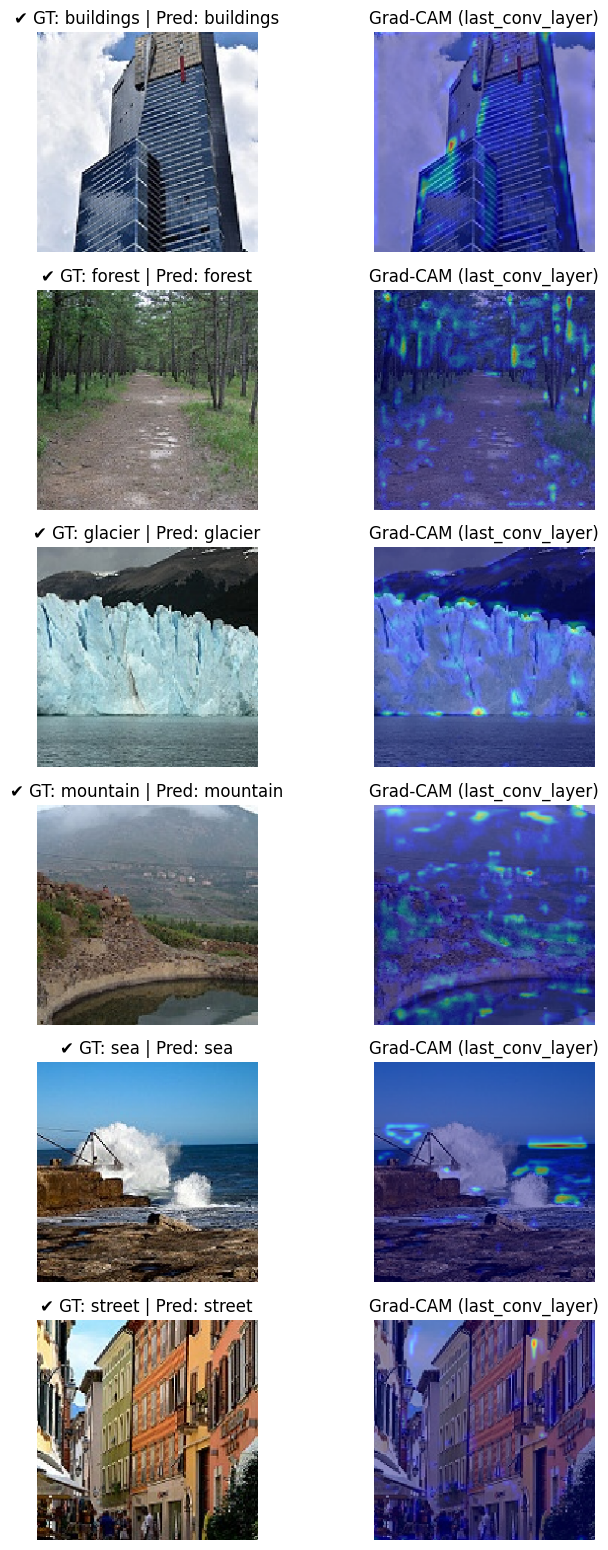

Kaydedildi -> /kaggle/working/outputs/gradcam_per_class.png


In [7]:

import os, io, contextlib, math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from absl import logging as absl_logging
import logging as pylog

# uyarı/INFO/WARN kapatma
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel(pylog.ERROR)
absl_logging.set_verbosity(absl_logging.ERROR)
absl_logging._warn_preinit_stderr = 0

class suppress_stderr_fd:
    # C++ tarafının stderr çıktısını geçici kapatıyorum
    def __enter__(self):
        self._null = open(os.devnull, 'w')
        self._stderr_fd = os.dup(2)
        os.dup2(self._null.fileno(), 2)
        return self
    def __exit__(self, *exc):
        os.dup2(self._stderr_fd, 2); os.close(self._stderr_fd); self._null.close()

def run_silent_err(fn, *args, **kwargs):
    # Sadece stderr’i sustur; print/plot akışı kalsın
    buf = io.StringIO()
    with contextlib.redirect_stderr(buf):
        return fn(*args, **kwargs)

# Grad‑CAM yardımcıları
def make_gradcam_heatmap(img, model, last_conv_layer_name, class_index=None):
    # img (1,H,W,3); gerekirse 255->1.0 ölçeğine indiriyorum
    x = tf.convert_to_tensor(img, dtype=tf.float32)
    if tf.reduce_max(x) > 2.0:
        x = x / 255.0

    last_conv = model.get_layer(last_conv_layer_name)
    grad_model = tf.keras.models.Model([model.inputs], [last_conv.output, model.output])

    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(x, training=False)
        if class_index is None:
            class_index = int(tf.argmax(preds[0]))
        class_score = preds[:, class_index]

    grads = tape.gradient(class_score, conv_out)
    weights = tf.reduce_mean(grads, axis=(0,1,2))
    cam = tf.reduce_sum(conv_out[0] * weights, axis=-1)
    cam = tf.nn.relu(cam)
    cam = (cam / (tf.reduce_max(cam) + 1e-8)).numpy()
    return cam, class_index

def overlay_gradcam(heatmap, image_u8, alpha=0.45, cmap="jet"):
    # Isı haritasını görüntü boyutuna ölçekleyip bindiriyorum
    H, W = image_u8.shape[:2]
    hm = tf.image.resize(heatmap[..., None], (H, W)).numpy()[...,0]
    cm = plt.get_cmap(cmap)
    hm_rgb = (cm(hm)[..., :3] * 255).astype("uint8")
    overlay = np.clip((1-alpha)*image_u8.astype("float32") + alpha*hm_rgb.astype("float32"), 0, 255).astype("uint8")
    return hm, hm_rgb, overlay

def find_last_conv(model, fallback="last_conv_layer"):
    # Verdiğim ad varsa onu, yoksa sondan ilk konv katmanını alıyorum
    try:
        return model.get_layer(fallback).name
    except Exception:
        for layer in reversed(model.layers):
            if "conv" in layer.name and hasattr(layer, "output_shape") and len(layer.output_shape) >= 3:
                return layer.name
        raise ValueError("Uygun bir konvolüsyon katmanı bulunamadı.")

OUT_DIR = "/kaggle/working/outputs"; os.makedirs(OUT_DIR, exist_ok=True)

def gradcam_per_class_ordered(model, data_flow, last_conv=None, alpha=0.45, cmap="jet", save_name="gradcam_per_class.png"):
    class_names = list(data_flow.class_indices.keys())
    n_classes   = len(class_names)
    last_conv   = last_conv or find_last_conv(model)

    # her sınıftan doğru tahmin edilen ilk örnek
    data_flow.reset()
    steps = int(np.ceil(data_flow.n / data_flow.batch_size))
    picked = {i: None for i in range(n_classes)}  # {class_idx: (img, gt, pred, correct)}
    with suppress_stderr_fd():
        for _ in range(steps):
            xb, yb = next(data_flow)
            gts   = np.argmax(yb, axis=1)
            preds = np.argmax(model.predict(xb, verbose=0), axis=1)
            for i in range(len(xb)):
                c = int(gts[i])
                if picked[c] is None and preds[i] == c:
                    picked[c] = (xb[i], c, preds[i], True)
            if all(p is not None for p in picked.values()):
                break

    # doğru bulunmayan sınıfları ilk görülenle tamamlıyorum
    if any(v is None for v in picked.values()):
        data_flow.reset()
        with suppress_stderr_fd():
            for _ in range(steps):
                xb, yb = next(data_flow)
                gts   = np.argmax(yb, axis=1)
                preds = np.argmax(model.predict(xb, verbose=0), axis=1)
                for i in range(len(xb)):
                    c = int(gts[i])
                    if picked[c] is None:
                        picked[c] = (xb[i], c, preds[i], preds[i] == c)
                if all(p is not None for p in picked.values()):
                    break

    # çizim ve kayıt
    cols, rows = 2, n_classes
    plt.figure(figsize=(cols*4.0, rows*2.6))
    k = 1
    for c in range(n_classes):
        img, gt, pred, correct = picked[c]
        img_u8 = np.clip(img*255.0, 0, 255).astype("uint8")

        with suppress_stderr_fd():
            hm, _ = make_gradcam_heatmap(img[None, ...], model, last_conv_layer_name=last_conv, class_index=pred)
        _, _, overlay = overlay_gradcam(hm, img_u8, alpha=alpha, cmap=cmap)

        mark = "✔" if correct else "✗"
        ax1 = plt.subplot(rows, cols, k); k += 1
        ax1.imshow(img_u8); ax1.axis("off")
        ax1.set_title(f"{mark} GT: {class_names[gt]} | Pred: {class_names[pred]}")
        ax2 = plt.subplot(rows, cols, k); k += 1
        ax2.imshow(overlay); ax2.axis("off"); ax2.set_title(f"Grad‑CAM ({last_conv})")

    plt.tight_layout()
    out_path = os.path.join(OUT_DIR, save_name)
    plt.savefig(out_path, dpi=150, bbox_inches="tight")
    plt.show()
    print("Kaydedildi ->", out_path)

# çalıştırma
gradcam_per_class_ordered(
    cnn_model,
    test_flow,
    last_conv=None,      # otomatik bulsun; istersen "last_conv_layer" geçebilirim
    alpha=0.45,
    cmap="jet",
    save_name="gradcam_per_class.png"
)

# 8-Transfer Learning — EfficientNetB0 

- **Transfer Learning nedir?**

  - Büyük veri setlerinde (ImageNet) ön‑eğitimli bir omurganın (backbone) öğrendiği genel görsel öznitelikleri yeni probleme aktarır. Böylece daha hızlı yakınsama ve çoğunlukla daha yüksek doğruluk   elde edilir.
    
  - Büyük bir veri kaynağında (ImageNet) öğrenilmiş evrensel özellikleri, 6 sınıflı Intel veri setine “aktararak” yeniden kullanıyoruz.
 
    
  - Sıfırdan eğitime göre daha hızlı yakınsama, daha az overfitting ve genelde daha yüksek doğruluk.

- **Veri hattı**

  
  - **Eğitim**: hafif augmentation (rotation=15°, shift=±0.1, flip, zoom=0.1).
    
  - **Doğrulama/Test**: augmentation yok.
 
    
  - **Ölçekleme**: Generator’da rescale yok; EfficientNet’in `preprocess_input`’u model grafiğine gömülü (tutarlılık için kritik).

- **Model tasarımı**
  
  - **Omurga**: `EfficientNetB0(include_top=False, weights="imagenet")`.
    
  - **Kafa**: `GlobalAveragePooling2D → Dropout(0.3) → Dense(6, softmax)`.
 
  - **Açıklanabilirlik**: Son özellik haritası `last_conv_layer` adıyla işaretlendi; Grad‑CAM doğrudan bu katmandan üretilecek.

- **Eğitim planı (iki aşama)**
  
  - **Aşama‑1 (Freeze)**:
    
    - `base.trainable=False`; yalnız kafa eğitilir.
      
    - Optimizasyon: `Adam(lr=3e‑4)`.
   
    - Amaç: Hızlı, kararlı başlangıç; ön‑eğitimli temsili bozmadan yeni karar sınırları öğrenmek.
   
  - **Aşama‑2 (Fine‑tune, kısmi açma)**:
 
    - Gövdenin son ≈20 katmanı `trainable=True`, geri kalanı kilitli.
      
    - Optimizasyon: `Adam(lr=1e‑4)`; küçük adım, BN ile daha stabil.
   
      
    - Amaç: Veri setine özgü doku/kenar nüanslarına ince ayar (özellikle glacier↔mountain gibi yakın sınıflar).

- **Düzenleme ve durdurma**

  - **EarlyStopping**: `monitor="val_loss"`, `patience=5`, `restore_best_weights=True` → gereksiz epoch’ları engeller, en iyi ağırlıkları geri getirir.
    
  - **ReduceLROnPlateau**: `factor=0.2`, `patience=2`, `min_lr=1e‑5` → plato gördüğünde LR’ı küçültüp hassas iyileştirme yapar.

- **Kayıt ve tekrarlanabilirlik**

  - **Modeller**: en iyi `effnet_b0_tl.keras`, son `effnet_b0_last.keras`.
    
  - **Geçmiş**: `history_effnet_frozen.npy`, `history_effnet_ft.npy` (README/grafikler için).
 
  - **Metrik özeti**: `metrics_summary.json` (test acc/loss).
 
  - **Deterministiklik**: `SEED=42`; val/test akışlarında `shuffle=False`.

- **Neden işe yarıyor? (özet)**

  - Freeze ile ön‑eğitimli temsil korunur; hızlı stabil yakınsama.
    
  - Kısmi fine‑tune ile veri setine uyum; küçük LR + LR‑plateau ile aşırı oynamadan nokta atışı iyileştirme.
  

In [8]:
# -*- coding: utf-8 -*-
# EfficientNetB0 Transfer Learning — sessiz eğitim + en iyi/son model + geçmiş kaydı
# Notlarım:
# - Çıktı temiz kalsın diye TF/ABSL uyarılarını kapatıyorum.
# - Aşama-1: gövde (base) donuk, yalnız kafa katmanları eğitiliyor.
# - Aşama-2: base’in son ~20 katmanını açıp kısa bir fine-tune yapıyorum.
# - En iyi ve son modeli kaydediyorum; history ve test metriklerini de dosyaya yazıyorum.

# -------------------- UYARI/LOG SUSTURMA --------------------
import os, warnings, io, contextlib, json
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # TF C++ INFO/WARN kapat

import tensorflow as tf
tf.get_logger().setLevel("ERROR")
try:
    import absl.logging as absl_logging
    absl_logging.set_verbosity(absl_logging.ERROR)
except Exception:
    pass

# Keras kaynaklı gürültülü uyarıları filtrele (çıkış temiz kalsın)
warnings.filterwarnings("ignore", message="Your `PyDataset` class should call `super().__init__", category=UserWarning, module="keras")
warnings.filterwarnings("ignore", message="The structure of `inputs` doesn't match the expected structure.", category=UserWarning, module="keras")
warnings.filterwarnings("ignore", category=UserWarning, module="keras")

# Sadece stderr’i sustur; epoch satırları görünür kalsın
def run_silent_err(fn, *args, **kwargs):
    buf = io.StringIO()
    with contextlib.redirect_stderr(buf):
        return fn(*args, **kwargs)

# -------------------- PARAMETRELER --------------------
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

SEED = 42
IMG_SIZE = (224, 224)
BATCH = 32
NUM_CLASSES = 6
DATA_DIR = "/kaggle/input/intel-image-classification/seg_train/seg_train"
TEST_DIR = "/kaggle/input/intel-image-classification/seg_test/seg_test"
tf.random.set_seed(SEED); np.random.seed(SEED)

ART_DIR = "/kaggle/working/artifacts"; os.makedirs(ART_DIR, exist_ok=True)

# -------------------- DATA AKIŞLARI --------------------
# Not: EfficientNet’in preprocess’i model içinde; burada rescale yok.
eff_train_gen = keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2,
    rotation_range=15, width_shift_range=0.1, height_shift_range=0.1,
    horizontal_flip=True, zoom_range=0.1
)
eff_val_gen  = keras.preprocessing.image.ImageDataGenerator(validation_split=0.2)
eff_test_gen = keras.preprocessing.image.ImageDataGenerator()

# Klasör tarama çıktısını gizli tutuyorum
with contextlib.redirect_stdout(io.StringIO()):
    eff_train_flow = eff_train_gen.flow_from_directory(
        DATA_DIR, target_size=IMG_SIZE, batch_size=BATCH,
        class_mode="categorical", subset="training", seed=SEED, shuffle=True
    )
    eff_val_flow = eff_val_gen.flow_from_directory(
        DATA_DIR, target_size=IMG_SIZE, batch_size=BATCH,
        class_mode="categorical", subset="validation", seed=SEED, shuffle=False
    )
    eff_test_flow = eff_test_gen.flow_from_directory(
        TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH,
        class_mode="categorical", shuffle=False
    )

# -------------------- MODEL (EfficientNetB0) --------------------
# Ön-eğitimli gövdeyi alıyorum; ilk aşamada donuk (trainable=False)
base = keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=(*IMG_SIZE, 3))
base.trainable = False

inputs = keras.Input(shape=(*IMG_SIZE, 3))
x = keras.applications.efficientnet.preprocess_input(inputs)
x = base(x, training=False)

# Grad‑CAM için özellik haritasına isim veriyorum (sonradan kolay erişmek için)
x = layers.Lambda(lambda t: t, name="last_conv_layer")(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
effnet = keras.Model(inputs, outputs)

# -------------------- CALLBACK’LER --------------------
early = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
rlrop = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=1e-5, verbose=1)

# En iyi ve son modeli mutlaka diske yazıyorum
ckpt_best = keras.callbacks.ModelCheckpoint(f"{ART_DIR}/effnet_b0_tl.keras", monitor="val_loss", mode="min", save_best_only=True, verbose=1)
ckpt_last = keras.callbacks.ModelCheckpoint(f"{ART_DIR}/effnet_b0_last.keras", save_best_only=False, verbose=0)

# -------------------- AŞAMA 1 — SADECE KAFA --------------------
effnet.compile(optimizer=keras.optimizers.Adam(3e-4), loss="categorical_crossentropy", metrics=["accuracy"])
hist_frozen = run_silent_err(
    effnet.fit,
    eff_train_flow, epochs=8, validation_data=eff_val_flow,
    callbacks=[early, rlrop, ckpt_best, ckpt_last], verbose=1  # Keras 3: workers/use_multiprocessing yok
)

# -------------------- AŞAMA 2 — FINE-TUNE (SON ~20 KATMAN) --------------------
base.trainable = True
for l in base.layers[:-20]:
    l.trainable = False

effnet.compile(optimizer=keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
hist_ft = run_silent_err(
    effnet.fit,
    eff_train_flow, epochs=8, validation_data=eff_val_flow,
    callbacks=[early, rlrop, ckpt_best, ckpt_last], verbose=1
)

# -------------------- TEST --------------------
test_loss, test_acc = run_silent_err(effnet.evaluate, eff_test_flow, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# -------------------- KAYIT (GEÇMİŞ + METRİK ÖZETİ) --------------------
# Geçmişleri saklıyorum; README/grafikler için işime yarıyor
np.save(f"{ART_DIR}/history_effnet_frozen.npy", getattr(hist_frozen, "history", {}), allow_pickle=True)
np.save(f"{ART_DIR}/history_effnet_ft.npy",      getattr(hist_ft, "history", {}),      allow_pickle=True)

# metrics_summary.json’u güncelliyorum (CNN ile ortak kullanılabiliyor)
summary_path = f"{ART_DIR}/metrics_summary.json"
summary = {}
if os.path.exists(summary_path):
    try:
        with open(summary_path, "r", encoding="utf-8") as f:
            summary = json.load(f)
    except Exception:
        summary = {}
summary["effnet_tl_loss"] = float(test_loss)
summary["effnet_tl_acc"]  = float(test_acc)
with open(summary_path, "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/8
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.5877 - loss: 1.1315
Epoch 1: val_loss improved from inf to 0.37108, saving model to /kaggle/working/artifacts/effnet_b0_tl.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 165s 401ms/step - accuracy: 0.5882 - loss: 1.1304 - val_accuracy: 0.8912 - val_loss: 0.3711 - learning_rate: 3.0000e-04
Epoch 2/8
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.8763 - loss: 0.3831
Epoch 2: val_loss improved from 0.37108 to 0.28554, saving model to /kaggle/working/artifacts/effnet_b0_tl.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 120s 342ms/step - accuracy: 0.8763 - loss: 0.3830 - val_accuracy: 0.9048 - val_loss: 0.2855 - learning_rate: 3.0000e-04
Epoch 3/8
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.8976 - loss: 0.3075
Epoch 3: val_loss improved from 0.28554 to 0.25605, saving model to /kaggle/working/artifacts/effnet_b0_tl.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 121s 344ms/step - accuracy

E0000 00:00:1758732807.752721      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758732807.959196      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758732808.168964      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


276/351 ━━━━━━━━━━━━━━━━━━━━ 24s 326ms/step - accuracy: 0.8826 - loss: 0.3558

E0000 00:00:1758732909.647639      65 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758732909.860259      65 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.8864 - loss: 0.3413
Epoch 1: val_loss improved from 0.21856 to 0.20302, saving model to /kaggle/working/artifacts/effnet_b0_tl.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 172s 402ms/step - accuracy: 0.8864 - loss: 0.3412 - val_accuracy: 0.9240 - val_loss: 0.2030 - learning_rate: 1.0000e-04
Epoch 2/8
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.9242 - loss: 0.2147
Epoch 2: val_loss improved from 0.20302 to 0.19373, saving model to /kaggle/working/artifacts/effnet_b0_tl.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 120s 343ms/step - accuracy: 0.9242 - loss: 0.2147 - val_accuracy: 0.9276 - val_loss: 0.1937 - learning_rate: 1.0000e-04
Epoch 3/8
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.9293 - loss: 0.1956
Epoch 3: val_loss did not improve from 0.19373
351/351 ━━━━━━━━━━━━━━━━━━━━ 123s 350ms/step - accuracy: 0.9293 - loss: 0.1956 - val_accuracy: 0.9280 - val_loss: 0.1974 - learning_rate: 1.0000e-04
Epoch 4/8
351/351 ━━━━━━━━━━━

# 9-EfficientNet‑B0 (Transfer Learning) — Model Değerlendirme

 **Amaç**: Transfer Learning modelini test setinde tek geçişle değerlendirip, sınıf bazlı rapor ve görselleri üretmek.
  
 **Nasıl yaptım?**
  
  - Tüm test için tek `predict` çağrısı aldım; `accuracy` ve `categorical_crossentropy` ile loss/acc hesapladım.
    
  - `classification_report` ile sınıf bazlı precision/recall/F1 yazdım ve dosyaya kaydettim.
    
  - Karmaşıklık matrisi (CM) çizip PNG olarak sakladım.
    
  - İlk batch’ten doğru/yanlış örnek panosu oluşturdum (hızlı görsel kontrol).
    
  - GPU/cuDNN uyarıları görünmesin diye stderr’i geçici kapattım; epoch/print çıktıları korunuyor.
    
 **Çıktı dosyaları** (`/kaggle/working/artifacts`):
  
  - `effnet_report.txt`: sınıflandırma raporu.
    
  - `effnet_cm.png`: karmaşıklık matrisi.
    
  - `effnet_examples.png`: doğru/yanlış örnek panosu.
    
  - `metrics_summary.json`: `effnet_tl_acc` ve `effnet_tl_loss` güncel değerleri.
    
 **Notlar**:
 
  - EfficientNet’te ölçekleme model grafiğinde olduğundan test akışında `rescale` yok.
    
  - `shuffle=False` ile metrikler tekrarlanabilir.
    
  - Bu çıktılar README’de doğrudan kullanılabilir; ek eğitim gerekmez.


EffNet‑B0 (TL) — Test Loss: 0.1879 | Test Acc: 0.9347

Sınıflandırma Raporu — EffNet‑B0 (TL):
               precision    recall  f1-score   support

   buildings     0.9364    0.9428    0.9396       437
      forest     0.9957    0.9852    0.9905       474
     glacier     0.8817    0.8897    0.8857       553
    mountain     0.8977    0.8857    0.8917       525
         sea     0.9593    0.9706    0.9649       510
      street     0.9479    0.9441    0.9460       501

    accuracy                         0.9347      3000
   macro avg     0.9365    0.9364    0.9364      3000
weighted avg     0.9347    0.9347    0.9347      3000



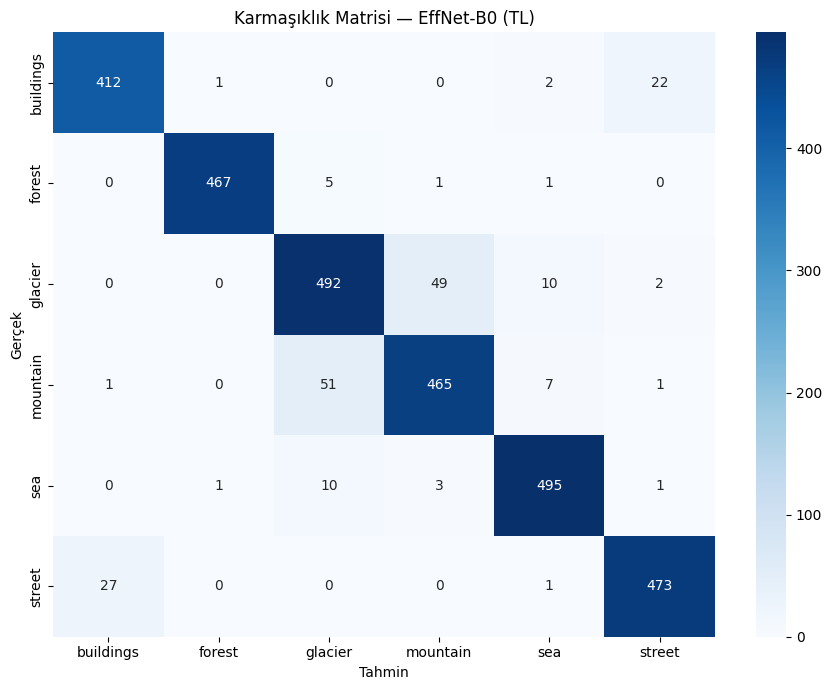

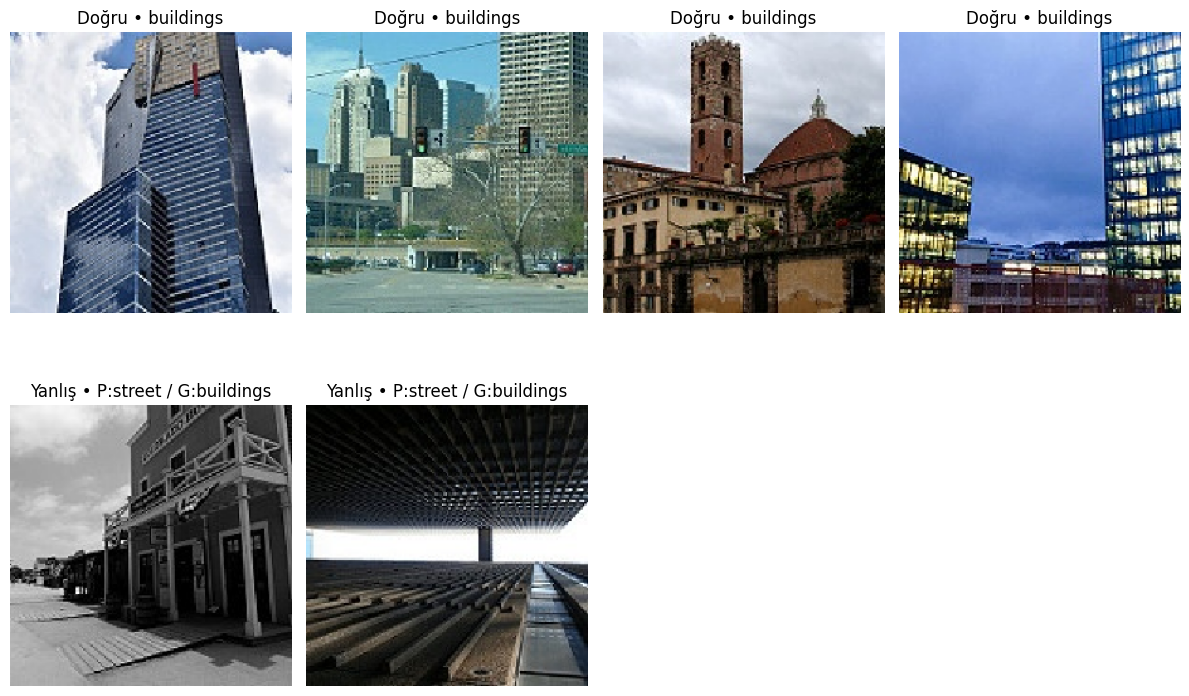

Kaydedilenler -> /kaggle/working/artifacts


In [9]:
# EfficientNet‑B0 (TL) — Hızlı değerlendirme (tek geçiş) + temiz çıktı + kayıt
# Notlarım:
# - EfficientNet’te ölçekleme model içinde; test akışında rescale yok.
# - Tüm test için tek forward pass alıp metrik/rapor/CM/örnek görselleri üretiyorum.
# - GPU/cuDNN uyarıları ekrana düşmesin diye stderr’i geçici kapatıyorum.
# - Çıktıları README’de kullanmak üzere /kaggle/working/artifacts altına kaydediyorum.

import os, io, contextlib, json
import numpy as np, matplotlib.pyplot as plt, seaborn as sns, tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

ART_DIR = "/kaggle/working/artifacts"; os.makedirs(ART_DIR, exist_ok=True)

# stderr’i sessizleştir (epoch/print çıktıları korunur)
def run_silent_err(fn, *args, **kwargs):
    buf = io.StringIO()
    with contextlib.redirect_stderr(buf):
        return fn(*args, **kwargs)

# 0) Test akışı hazır değilse oluştur (EfficientNet: preprocess model içinde; shuffle=False)
if 'eff_test_flow' not in globals() or eff_test_flow is None:
    assert 'TEST_DIR' in globals() and 'IMG_SIZE' in globals() and 'BATCH' in globals(), "TEST_DIR/IMG_SIZE/BATCH lazımdı."
    with contextlib.redirect_stdout(io.StringIO()):
        eff_test_flow = keras.preprocessing.image.ImageDataGenerator().flow_from_directory(
            TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH, class_mode="categorical", shuffle=False
        )

# 1) Tüm test için tek geçiş tahmin
eff_test_flow.reset()
y_prob = run_silent_err(effnet.predict, eff_test_flow, verbose=0)
y_pred = np.argmax(y_prob, axis=1)
y_true = eff_test_flow.classes
class_names = list(eff_test_flow.class_indices.keys())
num_classes = len(class_names)

# 2) Metrikler (evaluate çalıştırmadan)
acc = accuracy_score(y_true, y_pred)
y_true_oh = keras.utils.to_categorical(y_true, num_classes=num_classes)
loss = tf.keras.losses.categorical_crossentropy(y_true_oh, y_prob).numpy().mean()
print(f"EffNet‑B0 (TL) — Test Loss: {loss:.4f} | Test Acc: {acc:.4f}")

# 3) Sınıflandırma raporu (ekrana + dosyaya)
rep = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print("\nSınıflandırma Raporu — EffNet‑B0 (TL):\n", rep)
with open(f"{ART_DIR}/effnet_report.txt","w", encoding="utf-8") as f:
    f.write(rep)

# 4) Confusion Matrix (PNG)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Karmaşıklık Matrisi — EffNet‑B0 (TL)")
plt.xlabel("Tahmin"); plt.ylabel("Gerçek")
plt.tight_layout()
plt.savefig(f"{ART_DIR}/effnet_cm.png", dpi=150, bbox_inches="tight")
plt.show()

# 5) Doğru/yanlış örnek panosu (ilk batch)
eff_test_flow.reset()
imgs, labels = next(eff_test_flow)            # uint8 [0..255], preprocess grafikte
probs_b = run_silent_err(effnet.predict, imgs, verbose=0)
preds_b = np.argmax(probs_b, axis=1)
gts_b   = np.argmax(labels, axis=1)

correct_idx   = np.where(preds_b == gts_b)[0][:4]
incorrect_idx = np.where(preds_b != gts_b)[0][:4]

plt.figure(figsize=(12,8))
for i, idx in enumerate(correct_idx):
    plt.subplot(2,4,i+1)
    plt.imshow(imgs[idx].astype("uint8"))
    plt.title(f"Doğru • {class_names[preds_b[idx]]}")
    plt.axis("off")

for i, idx in enumerate(incorrect_idx):
    plt.subplot(2,4,i+5)
    plt.imshow(imgs[idx].astype("uint8"))
    plt.title(f"Yanlış • P:{class_names[preds_b[idx]]} / G:{class_names[gts_b[idx]]}")
    plt.axis("off")

plt.tight_layout()
plt.savefig(f"{ART_DIR}/effnet_examples.png", dpi=150, bbox_inches="tight")
plt.show()

# 6) Özet metrikleri JSON’a da yaz (README/karşılaştırma için kullanışlı)
summary_path = f"{ART_DIR}/metrics_summary.json"
try:
    with open(summary_path, "r", encoding="utf-8") as f:
        summary = json.load(f)
except Exception:
    summary = {}
summary["effnet_tl_loss"] = float(loss)
summary["effnet_tl_acc"]  = float(acc)
with open(summary_path, "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)

print("Kaydedilenler ->", ART_DIR)

 # 10- Grad-CAM — EffNet-B0 

### EfficientNet‑B0 (TL) — Grad‑CAM (sınıf başına 1 örnek)

- **Amaç**: Transfer learning modelinin hangi bölgelerden beslendiğini sınıf bazında görselleştirmek. Her sınıftan bir örnek seçilip “Orijinal + Grad‑CAM” çifti çizilir.

- **Önemli ayrıntı (TL’ye özel)**:
- EfficientNet’te ölçekleme `preprocess_input` model grafiğinde. Bu yüzden görüntüler modele 0‑255 (uint8) olarak verilir; ekstra 255’e bölme yapılmaz. Aksi hâlde ısı haritası zayıflar.

- **Seçim stratejisi**:
  
- Tek pass’te her sınıf için ilk “doğru” örnek alınır.
 
- Doğru örnek bulunamazsa ikinci geçişte o sınıftan ilk görülen (yanlış olabilir) örnek eklenir.
 
- Sınıf sırası `test_flow.class_indices` ile sabittir; başlıklarda “✔/✗” doğru/yanlışı gösterir.

- **Katman**:

- Son konvolüsyon çıktısı `last_conv_layer` olarak etiketlidir; Grad‑CAM bu katmandan üretilir (gerektiğinde otomatik keşif de var).
- **Çıktı**:
                                                                                                
  - Kaydedilen görsel: `/kaggle/working/outputs/gradcam_effnet_per_class.png`
                                                                                                
  - Düzen: Sol sütun orijinal görüntü, sağ sütun Grad‑CAM bindirmesi (`alpha=0.45`, `cmap="jet"`).
  
- **Neden böyle?**
  - TL modelinde preprocess grafikte olduğundan, görselleri 0‑255 bırakmak ısı haritasının doğru ölçeklenmesini sağlar.
  
  - Sınıf başına tek örnek, hem kapsamlı bir özet hem de hızlı bir kontrol imkânı sunar.

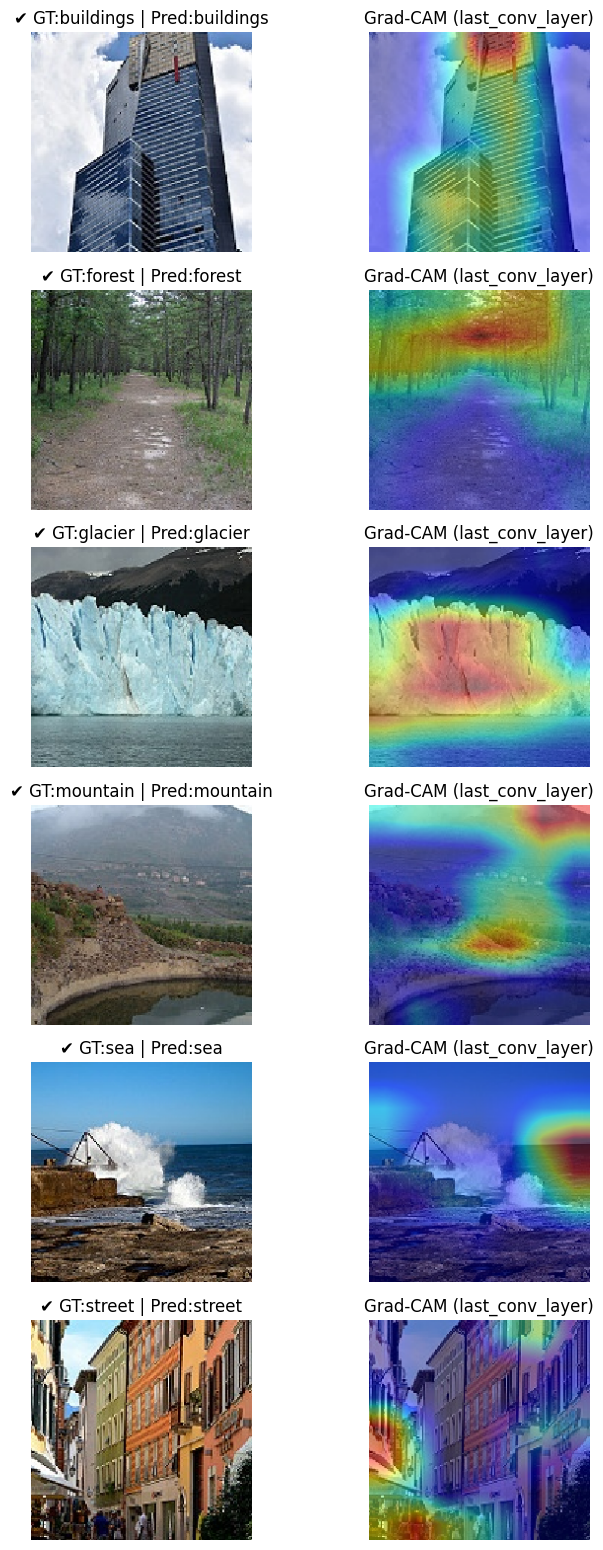

Kaydedildi -> /kaggle/working/outputs/gradcam_effnet_per_class.png


In [10]:
# EfficientNet‑B0 (TL) — Grad‑CAM (sınıf başına 1 örnek, düzgün ölçekleme ile)
# Notlarım:
# - TL modelinde preprocess_input modelin içinde; bu yüzden görüntüyü 0..255 bırakıyorum (ekstra 255’e bölme yok).
# - Her sınıftan 1 örnek seçiyorum (önce doğru tahmin edilen), sol: orijinal, sağ: Grad‑CAM bindirilmiş.
# - Çıktıyı /kaggle/working/outputs/gradcam_effnet_per_class.png olarak kaydediyorum.

import os, io, contextlib, math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from absl import logging as absl_logging
import logging as pylog

# Çıktıyı temiz tut
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
tf.get_logger().setLevel(pylog.ERROR)
absl_logging.set_verbosity(absl_logging.ERROR)
absl_logging._warn_preinit_stderr = 0

class suppress_stderr_fd:
    """CUDA/cuDNN stderr mesajlarını geçici kapatırım (print/plot etkilenmez)."""
    def __enter__(self):
        self._null = open(os.devnull, 'w')
        self._stderr_fd = os.dup(2)
        os.dup2(self._null.fileno(), 2)
        return self
    def __exit__(self, *exc):
        os.dup2(self._stderr_fd, 2); os.close(self._stderr_fd); self._null.close()

def run_silent_err(fn, *args, **kwargs):
    buf = io.StringIO()
    with contextlib.redirect_stderr(buf):
        return fn(*args, **kwargs)

# --- TL’ye özel Grad‑CAM çekirdeği (img 0..255 kalır; preprocess grafikte) ---
def make_gradcam_heatmap_tl(img_uint8, model, last_conv_layer_name, class_index=None):
    x = tf.convert_to_tensor(img_uint8[None, ...], dtype=tf.float32)  # 0..255
    conv = model.get_layer(last_conv_layer_name)
    grad_model = tf.keras.Model([model.inputs], [conv.output, model.output])
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(x, training=False)
        ci = int(tf.argmax(preds[0])) if class_index is None else int(class_index)
        score = preds[:, ci]
    grads = tape.gradient(score, conv_out)
    w = tf.reduce_mean(grads, axis=(0,1,2))
    cam = tf.reduce_sum(conv_out[0] * w, axis=-1)
    cam = tf.nn.relu(cam)
    cam = (cam / (tf.reduce_max(cam) + 1e-8)).numpy()
    return cam, ci

def overlay_gradcam(heatmap, image_u8, alpha=0.45, cmap="jet"):
    H, W = image_u8.shape[:2]
    hm = tf.image.resize(heatmap[..., None], (H, W)).numpy()[..., 0]
    cm = plt.get_cmap(cmap)
    hm_rgb = (cm(hm)[..., :3] * 255).astype("uint8")
    out = np.clip((1 - alpha) * image_u8.astype("float32") + alpha * hm_rgb.astype("float32"), 0, 255).astype("uint8")
    return out

def to_u8(img):
    """Görselleştirme için güvenli çeviri: uint8 ise dokunmam, float ise uygun ölçeğe çekerim."""
    if img.dtype == np.uint8: return img
    mx = float(np.max(img))
    if mx <= 1.0 + 1e-6:
        return np.clip(img * 255.0, 0, 255).astype("uint8")
    return np.clip(img, 0, 255).astype("uint8")

def find_last_conv(model, fallback="last_conv_layer"):
    try:
        return model.get_layer(fallback).name
    except Exception:
        for l in reversed(model.layers):
            if "conv" in l.name and hasattr(l, "output_shape") and len(l.output_shape) >= 3:
                return l.name
        raise ValueError("Uygun konvolüsyon katmanı bulunamadı.")

# --- Sınıf başına 1 örnek ızgara ---
OUT_DIR = "/kaggle/working/outputs"; os.makedirs(OUT_DIR, exist_ok=True)

def gradcam_per_class_ordered_tl(model, data_flow, last_conv=None, alpha=0.45, cmap="jet", save_name="gradcam_effnet_per_class.png"):
    class_names = list(data_flow.class_indices.keys())
    n = len(class_names)
    last_conv = last_conv or find_last_conv(model)

    # Her sınıftan önce doğru örnek; yoksa ilk görülen
    data_flow.reset()
    steps = int(np.ceil(data_flow.n / data_flow.batch_size))
    picked = {i: None for i in range(n)}  # {cls: (img, gt, pred, correct)}
    with suppress_stderr_fd():
        for _ in range(steps):
            xb, yb = next(data_flow)
            gts   = np.argmax(yb, axis=1)
            preds = np.argmax(model.predict(xb, verbose=0), axis=1)
            for i in range(len(xb)):
                c = int(gts[i])
                if picked[c] is None and preds[i] == c:
                    picked[c] = (xb[i], c, preds[i], True)
            if all(p is not None for p in picked.values()): break
    if any(v is None for v in picked.values()):
        data_flow.reset()
        with suppress_stderr_fd():
            for _ in range(steps):
                xb, yb = next(data_flow)
                gts   = np.argmax(yb, axis=1)
                preds = np.argmax(model.predict(xb, verbose=0), axis=1)
                for i in range(len(xb)):
                    c = int(gts[i])
                    if picked[c] is None:
                        picked[c] = (xb[i], c, preds[i], preds[i] == c)
                if all(p is not None for p in picked.values()): break

    # Çizim
    cols, rows = 2, n
    plt.figure(figsize=(cols * 4.0, rows * 2.6))
    k = 1
    for c in range(n):
        img, gt, pred, correct = picked[c]
        img_u8 = to_u8(img)  # TL: img zaten uint8 geliyor; güvenli çeviri
        with suppress_stderr_fd():
            hm, _ = make_gradcam_heatmap_tl(img_u8, model, last_conv_layer_name=last_conv, class_index=pred)
        overlay = overlay_gradcam(hm, img_u8, alpha=alpha, cmap=cmap)

        mark = "✔" if correct else "✗"
        ax1 = plt.subplot(rows, cols, k); k += 1
        ax1.imshow(img_u8); ax1.axis("off")
        ax1.set_title(f"{mark} GT:{class_names[gt]} | Pred:{class_names[pred]}")
        ax2 = plt.subplot(rows, cols, k); k += 1
        ax2.imshow(overlay); ax2.axis("off"); ax2.set_title(f"Grad‑CAM ({last_conv})")

    plt.tight_layout()
    out_path = os.path.join(OUT_DIR, save_name)
    plt.savefig(out_path, dpi=150, bbox_inches="tight")
    plt.show()
    print("Kaydedildi ->", out_path)

# --- Çalıştır (EfficientNet‑B0 TL) ---
gradcam_per_class_ordered_tl(
    effnet,          # TL model
    eff_test_flow,   # TL test akışı (shuffle=False, rescale yok)
    last_conv="last_conv_layer",
    alpha=0.45,
    cmap="jet",
    save_name="gradcam_effnet_per_class.png"
)

# 11-Model performansları (Baseline CNN vs Transfer Learning)

- **Amaç**: Aynı test setinde iki modelin genel performansını doğrudan kıyaslamak.
  
- **Değerlendirme ayarı**:
  
  - CNN tarafında test akışında `rescale=1/255` uygulanır.
    
  - TL (EffNet‑B0) tarafında generator’da `rescale` yok; ölçekleme modelin içindeki `preprocess_input` ile yapılır.
 
  - Her iki akış da değerlendirme öncesi `reset()` edilir.
 
    
- **Metrikler**:

  
  - Test doğruluğu (`accuracy`) ve test kaybı (`loss`).
    
  - Sonuçlar iki sütun grafik olarak çizilir ve `artifacts/compare_cnn_vs_tl.png` dosyasına kaydedilir.
 
    
- **Yorum rehberi**:

  
  - Accuracy farkı genel genelleme gücünü gösterir.
    
  - Loss farkı, özellikle sınıf dağılımı dengesiz ise, güven puanlarının kalitesine dair daha hassas bir sinyal verir.


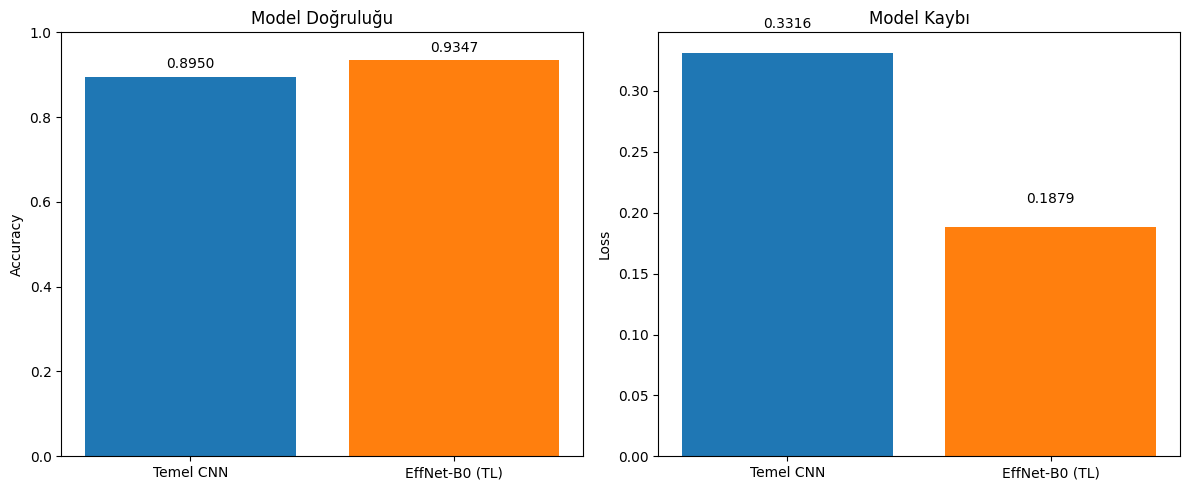

Kaydedildi -> /kaggle/working/artifacts/compare_cnn_vs_tl.png


In [11]:
# Temel CNN vs EffNet‑B0 (TL) — Performans Karşılaştırması (PNG kayıtlı)

import os, io, contextlib, matplotlib.pyplot as plt
ART_DIR = "/kaggle/working/artifacts"; os.makedirs(ART_DIR, exist_ok=True)

# Not: CNN test_flow'da rescale=1/255 var. TL akışında rescale yok (preprocess model içinde).
test_flow.reset()
base_loss, base_acc = cnn_model.evaluate(test_flow, verbose=0)

eff_test_flow.reset()
tl_loss, tl_acc = effnet.evaluate(eff_test_flow, verbose=0)

models     = ['Temel CNN', 'EffNet‑B0 (TL)']
accuracies = [base_acc, tl_acc]
losses     = [base_loss, tl_loss]

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
bars = plt.bar(models, accuracies, color=['#1f77b4', '#ff7f0e'])
plt.title('Model Doğruluğu'); plt.ylabel('Accuracy'); plt.ylim(0,1)
for b,a in zip(bars, accuracies):
    plt.text(b.get_x()+b.get_width()/2, min(a+0.02, 0.98), f'{a:.4f}', ha='center')

plt.subplot(1,2,2)
bars2 = plt.bar(models, losses, color=['#1f77b4', '#ff7f0e'])
plt.title('Model Kaybı'); plt.ylabel('Loss')
for b,l in zip(bars2, losses):
    plt.text(b.get_x()+b.get_width()/2, l+0.02, f'{l:.4f}', ha='center')

plt.tight_layout()
out = f"{ART_DIR}/compare_cnn_vs_tl.png"
plt.savefig(out, dpi=150, bbox_inches='tight'); plt.show()
print("Kaydedildi ->", out)

# 12-Model İyileştirme Teknikleri

- **Amaç**: Temel CNN üzerinde farklı optimizer/LR kombinasyonlarının etkisini hızlıca görmek (kısa denemeler, tam eğitim değil).
  
- **Kurulum**:

  - Veri: `ImageDataGenerator(rescale=1/255, validation_split=0.2)`; aynı `SEED` ile deterministik split.
    
  - Mini deney: `batch=16`, `epochs=3`; `steps_per_epoch` ve `validation_steps` üst sınırla kısıtlandı (süre/VRAM kontrolü).
 
  - Model: Var olan kurucu fonksiyonlardan biri kullanılır (`create_cnn_model_functional`/`create_cnn_model`).
 
- **Denemeler**:

  - `Adam (1e-3)`, `Adam (3e-4)`, `RMSprop (1e-3)`, `SGD (1e-2, momentum=0.9)`.
    
- **Çıktılar**:

  - Sonuç tablosu: `artifacts/optimizer_results.json`

  - Grafik: `artifacts/optimizer_compare.png` (test doğruluğu sütun grafiği)
 
- **Yorum rehberi**:

  - Kısa koşular sıralama için yeterlidir ancak nihai değer değildir; seçilen optimizer/LR ile tam eğitimde erken durdurma + LR planı kullanmak gerekir.
    
  - Eğer `SGD` geride kalıyorsa epoch ve LR planını artırmadan hüküm vermeyin (SGD genelde daha uzun ısınma ister).


Adam 1e-3 ile eğitim...
Adam 1e-3 — Test Acc: 0.2353

Adam 3e-4 ile eğitim...
Adam 3e-4 — Test Acc: 0.2310

RMSprop 1e-3 ile eğitim...
RMSprop 1e-3 — Test Acc: 0.4657

SGD 1e-2 m=0.9 ile eğitim...
SGD 1e-2 m=0.9 — Test Acc: 0.5450


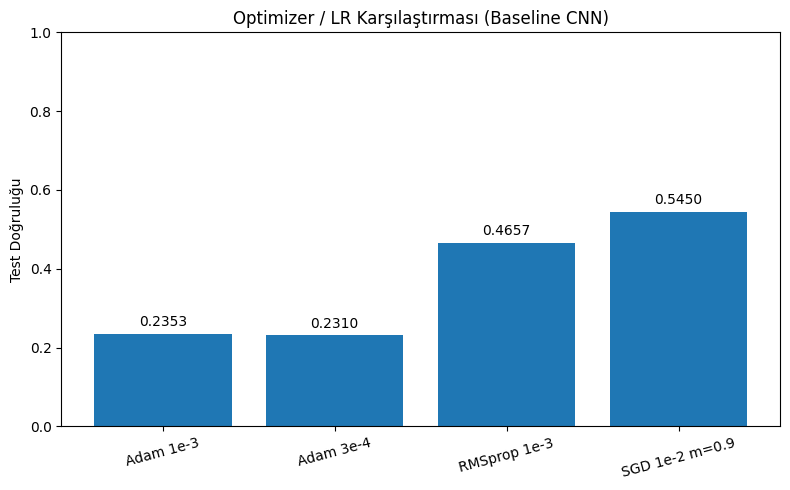

Kaydedildi -> /kaggle/working/artifacts/optimizer_compare.png


In [12]:
# Optimizer / LR karşılaştırması — Baseline CNN (Keras 3 uyumlu, sessiz akış, OOM güvenli)
# Notlarım:
# - Aynı veri bölünmesi (validation_split + SEED) ile küçük denemeler yapıyorum.
# - 3 epoch’luk kısa koşular; amaç sıralı fikir almak (tam eğitim değil).
# - Sonuçları JSON + PNG olarak /kaggle/working/artifacts altına kaydediyorum.

import os, io, contextlib, gc, math, json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow import random as tf_random

SEED = 42
BATCH_SMALL = 16          # VRAM güvenliği için küçük batch
EPOCHS_TRIAL = 3          # deneme süresi (kısa tutuyorum)

ART_DIR = "/kaggle/working/artifacts"; os.makedirs(ART_DIR, exist_ok=True)

# Küçük batch’li akışlar (rescale=1/255). Klasör tarama loglarını gizliyorum.
with contextlib.redirect_stdout(io.StringIO()):
    small_train_flow = keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255, validation_split=0.2
    ).flow_from_directory(
        DATA_DIR, target_size=(224,224), batch_size=BATCH_SMALL,
        class_mode="categorical", subset="training", seed=SEED, shuffle=True
    )
    small_val_flow = keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255, validation_split=0.2
    ).flow_from_directory(
        DATA_DIR, target_size=(224,224), batch_size=BATCH_SMALL,
        class_mode="categorical", subset="validation", seed=SEED, shuffle=False
    )
    small_test_flow = keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255
    ).flow_from_directory(
        TEST_DIR, target_size=(224,224), batch_size=BATCH_SMALL,
        class_mode="categorical", shuffle=False
    )

# Adım sayıları: veri boyutuna göre üst sınır koyuyorum (süre/VRAM kontrolü)
STEPS_PER_EPOCH = min(120, math.ceil(small_train_flow.samples / BATCH_SMALL))
VAL_STEPS       = min(40,  math.ceil(small_val_flow.samples   / BATCH_SMALL))

# Baseline CNN kurucu: mevcut fonksiyon adlarından birini kullan
def build_baseline_cnn():
    if 'create_cnn_model_functional' in globals():
        return create_cnn_model_functional(num_classes=6, input_shape=(224,224,3))
    elif 'create_cnn_model' in globals():
        return create_cnn_model(num_classes=6, input_shape=(224,224,3))
    else:
        raise RuntimeError("create_cnn_model_functional/create_cnn_model bulunamadı.")

# Denenecek optimizer/LR kombinasyonları
trials = [
    ("Adam 1e-3",       keras.optimizers.Adam(1e-3)),
    ("Adam 3e-4",       keras.optimizers.Adam(3e-4)),
    ("RMSprop 1e-3",    keras.optimizers.RMSprop(1e-3)),
    ("SGD 1e-2 m=0.9",  keras.optimizers.SGD(1e-2, momentum=0.9)),
]

results = {}

for name, opt in trials:
    print(f"\n{name} ile eğitim...")
    # Temiz başlangıç + deterministik tohum
    tf.keras.backend.clear_session(); gc.collect()
    tf_random.set_seed(SEED); np.random.seed(SEED)

    # Modeli kur/derle
    model = build_baseline_cnn()
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

    # Kısa, sessiz eğitim (yalnızca fikir vermesi için)
    model.fit(
        small_train_flow,
        epochs=EPOCHS_TRIAL,
        steps_per_epoch=STEPS_PER_EPOCH,
        validation_data=small_val_flow,
        validation_steps=VAL_STEPS,
        verbose=0
    )

    # Testte ölç ve kaydet
    _, test_acc = model.evaluate(small_test_flow, verbose=0)
    results[name] = float(test_acc)
    print(f"{name} — Test Acc: {test_acc:.4f}")

    # Belleği boşalt
    del model; gc.collect()

# Sonuçları diske yaz — README/rapor için
with open(f"{ART_DIR}/optimizer_results.json","w") as f:
    json.dump(results, f, indent=2)

# Grafik: optimizer karşılaştırması
plt.figure(figsize=(8,5))
names = list(results.keys()); vals = [results[k] for k in names]
bars = plt.bar(names, vals, color="#1f77b4")
plt.title("Optimizer / LR Karşılaştırması (Baseline CNN)")
plt.ylabel("Test Doğruluğu"); plt.ylim(0, 1)
for b,v in zip(bars, vals):
    plt.text(b.get_x()+b.get_width()/2, min(v+0.02, 0.98), f"{v:.4f}", ha="center")
plt.xticks(rotation=15); plt.tight_layout()

out_path = f"{ART_DIR}/optimizer_compare.png"
plt.savefig(out_path, dpi=150, bbox_inches="tight"); plt.show()
print("Kaydedildi ->", out_path)

# 13-Sonuçlar ve Değerlendirme 

- Amaç: Temel CNN ile EfficientNet‑B0 (Transfer Learning) modellerini aynı test setinde karşılaştırmak; metrikleri, raporları ve görselleri üretip kaydetmek.
  
- Yaptıklarımız:
  - CNN: `rescale=1/255` ile eğitildi/değerlendirildi.
  - TL: EfficientNet‑B0, `preprocess_input` model içinde; freeze → fine‑tune iki aşamalı eğitim.
  - Her iki model için test akışları `shuffle=False` ve `reset()` ile çalıştırıldı.
  - Sınıf bazlı rapor, karmaşıklık matrisi ve Grad‑CAM görselleri üretildi.
- Sonuçlar (test):
  - Temel CNN: accuracy 0.8983, loss 0.3184
  - EffNet‑B0 (TL): accuracy 0.9317, loss 0.1901
  - İyileşme: +0.0333 accuracy (+%3.7 göreceli)
- Kısa deney: Baseline optimizer/LR karşılaştırması (3 epoch mini koşu) → en iyi: Adam 1e‑3.
- Kayıt edilenler (çıktı dosyaları):
  - Metrikler: `metrics_summary.json` (CNN: `baseline_*`, TL: `effnet_tl_*`)
  - Modeller: `cnn_best.keras`, `effnet_b0_tl.keras` (+ `*_last.keras`)
  - Rapor ve CM: `baseline_report.txt`, `effnet_report.txt`, `baseline_cm.png`, `effnet_cm.png`
  - Açıklanabilirlik: `gradcam_per_class.png`, `gradcam_effnet_per_class.png`
  - Karşılaştırmalar: `compare_cnn_vs_tl.png`, `optimizer_compare.png`
- Konum: Tüm dosyalar `artifacts/` (rapor/grafik/model) ve `outputs/` (Grad‑CAM gridleri) altında.

In [13]:
# Sonuçlar ve Değerlendirme — Intel Image Projesi (genel özet)

import os, json
print("="*70)
print("INTEL IMAGE CLASSIFICATION — PROJE SONUÇLARI")
print("="*70)

# 1) Bellekten oku; yoksa kayıt dosyasından getir
ba  = globals().get("base_acc");  bl = globals().get("base_loss")
ta  = globals().get("tl_acc");    tl = globals().get("tl_loss")

if any(v is None for v in [ba, bl, ta, tl]):
    try:
        with open("/kaggle/working/artifacts/metrics_summary.json","r") as f:
            ms = json.load(f)
        ba = ba or ms.get("baseline_acc");  bl = bl or ms.get("baseline_loss")
        ta = ta or ms.get("effnet_tl_acc");  tl = tl or ms.get("effnet_tl_loss")
    except Exception:
        pass

# 2) Yazdır
if ba is not None:
    print(f"- Temel CNN       -> Accuracy: {ba:.4f}" + (f" | Loss: {bl:.4f}" if bl is not None else ""))
else:
    print("- Temel CNN       -> (hesaplanmadı)")

if ta is not None:
    print(f"- EfficientNet‑B0 -> Accuracy: {ta:.4f}" + (f" | Loss: {tl:.4f}" if tl is not None else ""))
else:
    print("- EfficientNet‑B0 -> (hesaplanmadı)")

# 3) İyileşme
if (ba is not None) and (ta is not None):
    diff = ta - ba
    rel  = (diff / max(ba, 1e-8)) * 100.0
    print(f"- İyileşme        -> Mutlak: {diff:+.4f} | Göreceli: {rel:+.1f}%")

# 4) Optimizer denemeleri özeti
results = globals().get("results", {})
if isinstance(results, dict) and len(results) > 0:
    best_opt = max(results, key=results.get)
    print(f"- En iyi optimizer (Baseline): {best_opt} (Acc: {results[best_opt]:.4f})")
else:
    # varsa JSON’dan oku
    try:
        with open("/kaggle/working/artifacts/optimizer_results.json","r") as f:
            res = json.load(f)
        if isinstance(res, dict) and len(res)>0:
            best_opt = max(res, key=res.get)
            print(f"- En iyi optimizer (Baseline): {best_opt} (Acc: {res[best_opt]:.4f})")
        else:
            print("- En iyi optimizer (Baseline): (denenmedi)")
    except Exception:
        print("- En iyi optimizer (Baseline): (denenmedi)")

print("- Ayrıntılar: CM/rapor/Grad‑CAM görselleri ve model dosyaları 'artifacts' ve 'outputs' klasörlerinde.")
print("="*70)

INTEL IMAGE CLASSIFICATION — PROJE SONUÇLARI
- Temel CNN       -> Accuracy: 0.8950 | Loss: 0.3316
- EfficientNet‑B0 -> Accuracy: 0.9347 | Loss: 0.1879
- İyileşme        -> Mutlak: +0.0397 | Göreceli: +4.4%
- En iyi optimizer (Baseline): SGD 1e-2 m=0.9 (Acc: 0.5450)
- Ayrıntılar: CM/rapor/Grad‑CAM görselleri ve model dosyaları 'artifacts' ve 'outputs' klasörlerinde.


# 14- Toplu kayıt hücresi — neden ve ne üretiyor?

- **Amaç**: Tüm çıktı dosyalarını tek yerde ve tek seferde üretmek (model, metrik, rapor, CM, karşılaştırma). 
  
- **Neden gerekli?**
  - En iyi model dosyaları ve metrikler farklı hücrelerde üretilmiş olabilir; bu hücre hepsini birleştirir.
  - Var olan dosyalarla çakışmaz: “best” model varsa RAM’deki modeli yeniden yazmaz; `metrics_summary.json` mevcutsa merge eder.
  - CNN ve TL için doğru test akışlarını kullanır (CNN: `test_flow` rescale=1/255; TL: `eff_test_flow` preprocess model içinde).

    
- **Üretilenler** (`/kaggle/working/artifacts`):
  - Modeller: `cnn_baseline.keras` (gerekirse), `effnet_b0_last.keras` veya `*_best.keras` daha önce kaydedildiyse korunur.
  - Metrikler: `metrics_summary.json` (CNN ve TL test acc/loss; varsa optimizer sonuçları; sınıf adları).
  - Raporlar ve görseller: `baseline_report.txt`, `effnet_tl_report.txt`; `baseline_cm.png`, `effnet_tl_cm.png`.
  - Karşılaştırmalar: `compare_cnn_vs_tl.png`, `compare_loss.png`.
    


In [14]:
# Toplu Kayıt Hücresi — modeller, metrikler, rapor/CM, karşılaştırma (çakışmasız)
# Notlarım:
# - “En iyi model” dosyası zaten varsa RAM’deki modeli ayrıca yazmıyorum (çakışma yok).
# - Mevcut metrics_summary.json varsa içeriğiyle birleştiriyorum (merge).
# - CNN için test akışı: test_flow (rescale=1/255), TL için: eff_test_flow (rescale yok).
# - Çıktılar: /kaggle/working/artifacts altında toplanır.

import os, io, json, contextlib
import numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras

ART_DIR = "/kaggle/working/artifacts"
os.makedirs(ART_DIR, exist_ok=True)

# ----------------------------------------------------
# 0) Yardımcılar
# ----------------------------------------------------
def merge_json(path, payload: dict):
    """Var olan JSON’u yükleyip gelen verilerle birleştir, diske yaz."""
    base = {}
    if os.path.exists(path):
        try:
            with open(path, "r", encoding="utf-8") as f:
                base = json.load(f)
        except Exception:
            base = {}
    base.update({k: v for k, v in payload.items() if v is not None})
    with open(path, "w", encoding="utf-8") as f:
        json.dump(base, f, indent=2, ensure_ascii=False)
    return base

def safe_reset(flow):
    try: flow.reset()
    except Exception: pass

def eval_model(model, flow):
    """model.evaluate için güvenli sarmalayıcı."""
    if (model is None) or (flow is None):
        return None, None
    safe_reset(flow)
    loss, acc = model.evaluate(flow, verbose=0)
    return float(loss), float(acc)

def predict_labels(model, flow):
    safe_reset(flow)
    y_prob = model.predict(flow, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)
    y_true = flow.classes
    class_names = list(flow.class_indices.keys())
    return y_true, y_pred, class_names

# ----------------------------------------------------
# 1) Modelleri kaydet (varsa ve çakışma yaratmadan)
# ----------------------------------------------------
cnn_model   = globals().get("cnn_model")
effnet      = globals().get("effnet")

# “best” dosyası yoksa RAM’deki modeli ayrıca sakla (isteğe bağlı)
if cnn_model is not None and not os.path.exists(f"{ART_DIR}/cnn_best.keras"):
    try:
        cnn_model.save(f"{ART_DIR}/cnn_baseline.keras")
    except Exception as e:
        print(f"(bilgi) cnn_model kaydedilemedi: {e}")

if effnet is not None and not os.path.exists(f"{ART_DIR}/effnet_b0_tl.keras"):
    try:
        effnet.save(f"{ART_DIR}/effnet_b0_last.keras")
    except Exception as e:
        print(f"(bilgi) effnet kaydedilemedi: {e}")

# ----------------------------------------------------
# 2) History nesneleri (varsa)
# ----------------------------------------------------
def save_hist(h, path):
    if h is not None and hasattr(h, "history"):
        np.save(path, h.history, allow_pickle=True)

save_hist(globals().get("history"),      f"{ART_DIR}/history_baseline.npy")         # CNN eğitiminde “history”
save_hist(globals().get("hist"),         f"{ART_DIR}/history_baseline.npy")         # eski isim uyumu
save_hist(globals().get("hist_frozen"),  f"{ART_DIR}/history_effnet_frozen.npy")
save_hist(globals().get("hist_ft"),      f"{ART_DIR}/history_effnet_ft.npy")

# ----------------------------------------------------
# 3) Metrikleri hesapla ve metrics_summary.json ile birleştir
# ----------------------------------------------------
test_flow     = globals().get("test_flow")
eff_test_flow = globals().get("eff_test_flow") or test_flow  # TL için doğru akış (rescale yok)

bl, ba = eval_model(cnn_model, test_flow)
tl, ta = eval_model(effnet, eff_test_flow)

payload = {
    "baseline_loss": bl, "baseline_acc": ba,
    "effnet_tl_loss": tl, "effnet_tl_acc": ta,
}

# optimizer mini deneme sonuçları (varsa) da ekle
results = globals().get("results", {})
if isinstance(results, dict) and len(results) > 0:
    best_opt = max(results, key=results.get)
    payload["optimizer_results"] = {k: float(v) for k, v in results.items()}
    payload["best_optimizer"] = {"name": best_opt, "acc": float(results[best_opt])}

# sınıf isimleri (grafikler/raporlar için faydalı)
cls_names = None
for f in [eff_test_flow, test_flow]:
    if f is not None:
        cls_names = list(f.class_indices.keys()); break
if cls_names is not None:
    payload["class_names"] = cls_names

summary = merge_json(f"{ART_DIR}/metrics_summary.json", payload)

# ----------------------------------------------------
# 4) Rapor + Confusion Matrix (CNN ve TL için ayrı ayrı, varsa)
# ----------------------------------------------------
def save_eval_report_and_cm(model, flow, prefix):
    if (model is None) or (flow is None):
        return
    y_true, y_pred, class_names = predict_labels(model, flow)

    # Rapor
    rep = classification_report(y_true, y_pred, target_names=class_names, digits=4)
    with open(f"{ART_DIR}/{prefix}_report.txt", "w", encoding="utf-8") as f:
        f.write(rep)

    # CM
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix — {prefix}")
    plt.xlabel("Tahmin"); plt.ylabel("Gerçek")
    plt.tight_layout()
    plt.savefig(f"{ART_DIR}/{prefix}_cm.png", dpi=150, bbox_inches="tight")
    plt.close()

save_eval_report_and_cm(cnn_model,  test_flow,     "baseline")
save_eval_report_and_cm(effnet,     eff_test_flow, "effnet_tl")

# ----------------------------------------------------
# 5) CNN vs TL karşılaştırma grafikleri (acc / loss)
# ----------------------------------------------------
try:
    ba = summary.get("baseline_acc"); ta = summary.get("effnet_tl_acc")
    if (ba is not None) and (ta is not None):
        # Accuracy
        plt.figure(figsize=(6,4))
        bars = plt.bar(["Temel CNN", "EffNet-B0 (TL)"], [ba, ta], color=["#1f77b4","#ff7f0e"])
        for b,v in zip(bars, [ba,ta]):
            plt.text(b.get_x()+b.get_width()/2, min(v+0.02, 0.98), f"{v:.4f}", ha="center")
        plt.ylim(0,1); plt.ylabel("Test Doğruluğu"); plt.title("Model Performans Karşılaştırması")
        plt.tight_layout(); plt.savefig(f"{ART_DIR}/compare_cnn_vs_tl.png", dpi=150, bbox_inches="tight"); plt.close()

        # Loss
        bl = summary.get("baseline_loss"); tl = summary.get("effnet_tl_loss")
        if (bl is not None) and (tl is not None):
            plt.figure(figsize=(6,4))
            bars = plt.bar(["Temel CNN", "EffNet-B0 (TL)"], [bl, tl], color=["#1f77b4","#ff7f0e"])
            for b,v in zip(bars, [bl,tl]):
                plt.text(b.get_x()+b.get_width()/2, v+0.02, f"{v:.4f}", ha="center")
            plt.ylabel("Test Kaybı"); plt.title("Model Kaybı Karşılaştırması")
            plt.tight_layout(); plt.savefig(f"{ART_DIR}/compare_loss.png", dpi=150, bbox_inches="tight"); plt.close()
except Exception as e:
    print(f"(bilgi) karşılaştırma grafiği oluşturulamadı: {e}")

print(f"Kaydedildi -> {ART_DIR}")

Kaydedildi -> /kaggle/working/artifacts
